
## RNN for data with time delays

* Per cast
* This one is smooth. I think is may be because of weight decay in Adam, and L1 loss


In [1]:

import pandas as pd
import numpy as np


In [2]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [3]:

import matplotlib 
## import pytorch_lightning as pl
import torch 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


In [4]:

## Requires Python = 3.9



## Parameters


In [5]:

window                 = 5   ## 90   ## 30          ## seq length

silicon_feature_index  = 0

avg_the_rows_parameter =  1   ##   15

vector_n_out = 24


## 1    ->  1 minute time step
## 15   -> 15 minute time step
## 1440 -> 24 hour time step
## 480  -> 8 hour shift
## 60   -> 1 hour time step



## Read the data


In [6]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [7]:

for_RNN_data_CIVS.head(5)


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0           1  0.719500                4.242439          2161.425209   
1           2  0.710486                4.174343          2168.238915   
2           3  0.666106                4.126144          2167.779119   
3           4  0.675145                4.120736          2166.974740   
4           5  0.776831                4.120331          2166.384674   

   NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0            9306.840913   184.818611                    0.0           0.0   
1            9336.364456   185.993447                    0.0           0.0   
2            9419.200115   185.828474                    0.0           0.0   
3            9564.165802   185.924481                    0.0           0.0   
4            9648.247637   185.942943                    0.0           0.0   

   Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SE_Uptake_f3  NW_Uptake_f3  SW_Uptake_f3  \
0           0.354        0.16  ...    182.533770    148.126483    192.512412   
1           0.313        0.83  ...    183.725050    148.161842    192.366046   
2           0.360        0.10  ...    195.812061    147.562523    198.423474   
3           0.319        0.34  ...    188.028883    147.807509    179.116839   
4           0.335        0.28  ...    200.141261    149.014319    186.052137   

   Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  SNORT_VALVE_POSITION_f3  \
0     37.369999    36.439999         9.86                98.334297   
1     35.540001    35.970001         9.03                98.334297   
2     34.849998    36.590000         9.13                98.334297   
3     34.009998    35.900002         8.82                98.334297   
4     34.380001    35.970001         8.73                98.334297   

   TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  cokerate_f4  
0     18.532928              36.602600        884.0  
1     18.397217              36.882963        884.0  
2     18.393974              36.568884        884.0  
3     18.370316              36.839147        884.0  
4     18.395860              36.658018        884.0  

[5 rows x 25 columns]

In [8]:

for_RNN_data_CIVS


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0              1  0.719500                4.242439          2161.425209   
1              2  0.710486                4.174343          2168.238915   
2              3  0.666106                4.126144          2167.779119   
3              4  0.675145                4.120736          2166.974740   
4              5  0.776831                4.120331          2166.384674   
...          ...       ...                     ...                  ...   
1378        1379  0.762500                4.204430          2169.361647   
1379        1380  0.646000                4.208539          2169.079601   
1380        1381  0.654667                4.212648          2168.797556   
1381        1382  0.591667                4.217784          2168.444999   
1382        1383  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SE_Uptake_f3  NW_Uptake_f3  \
0              0.354        0.16  ...    182.533770    148.126483   
1              0.313        0.83  ...    183.725050    148.161842   
2              0.360        0.10  ...    195.812061    147.562523   
3              0.319        0.34  ...    188.028883    147.807509   
4              0.335        0.28  ...    200.141261    149.014319   
...              ...         ...  ...           ...           ...   
1378           0.343        0.30  ...    185.900341    148.103530   
1379           0.324        0.30  ...    182.408576    148.106012   
1380           0.325        0.16  ...    181.684649    148.108493   
1381           0.335        0.26  ...    195.202191    148.111595   
1382           0.328        1.08  ...    220.149599    148.115317   

      SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       192.512412     37.369999    36.439999         9.86   
1       192.366046     35.540001    35.970001         9.03   
2       198.423474     34.849998    36.590000         9.13   
3       179.116839     34.009998    35.900002         8.82   
4       186.052137     34.380001    35.970001         8.73   
...            ...           ...          ...          ...   
1378    199.914193     35.900002    37.259998        10.04   
1379    193.501805     35.900002    37.259998        10.04   
1380    194.328694     35.580002    36.500000         9.30   
1381    215.606202     35.130001    37.470001        10.01   
1382    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...           ...                    ...   
1378                98.334297     18.209401              36.727897  

In [9]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [10]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [11]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [12]:

for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    

In [13]:

for_RNN_data_CIVS.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SI_f1                    1383 non-null   float64
 1   HOST_BLAST_MOISTURE_f3   1383 non-null   float64
 2   HOT_BLAST_TMP_NS_f3      1383 non-null   float64
 3   NAT_GAS _INJECTION_f3    1383 non-null   float64
 4   WINDRATE_f3              1383 non-null   float64
 5   HIGH_PURITY_OXYGEN_f3    1383 non-null   float64
 6   COAL_FLOW_f3             1383 non-null   float64
 7   Cast_Avg_Mn_f2           1383 non-null   float64
 8   Slag_Fe_f2               1383 non-null   float64
 9   Selec_Top_Gas_CO_f3      1383 non-null   float64
 10  Selec_Top_Gas_CO2_f3     1383 non-null   float64
 11  Selec_Top_Gas_H2_f3      1383 non-null   float64
 12  Selec_Top_Gas_N2_f3      1383 non-null   float64
 13  NE_Uptake_f3             1383 non-null   float64
 14  SE_Uptake_f3            


## Plots


In [14]:
'''
for_RNN_data_CIVS['MM_Timestamp_f1'] = for_RNN_data_CIVS['MM_Timestamp_f1'].astype("datetime64[ns]")

rc22 = for_RNN_data_CIVS['MM_Timestamp_f1'].astype("datetime64[ns]")
'''

'\nfor_RNN_data_CIVS[\'MM_Timestamp_f1\'] = for_RNN_data_CIVS[\'MM_Timestamp_f1\'].astype("datetime64[ns]")\n\nrc22 = for_RNN_data_CIVS[\'MM_Timestamp_f1\'].astype("datetime64[ns]")\n'

In [15]:

##rc22


In [16]:

plt.rcParams["figure.figsize"] = [15, 5]


In [17]:

## plt.plot(rc22, for_RNN_data_CIVS['SI_f1'])


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

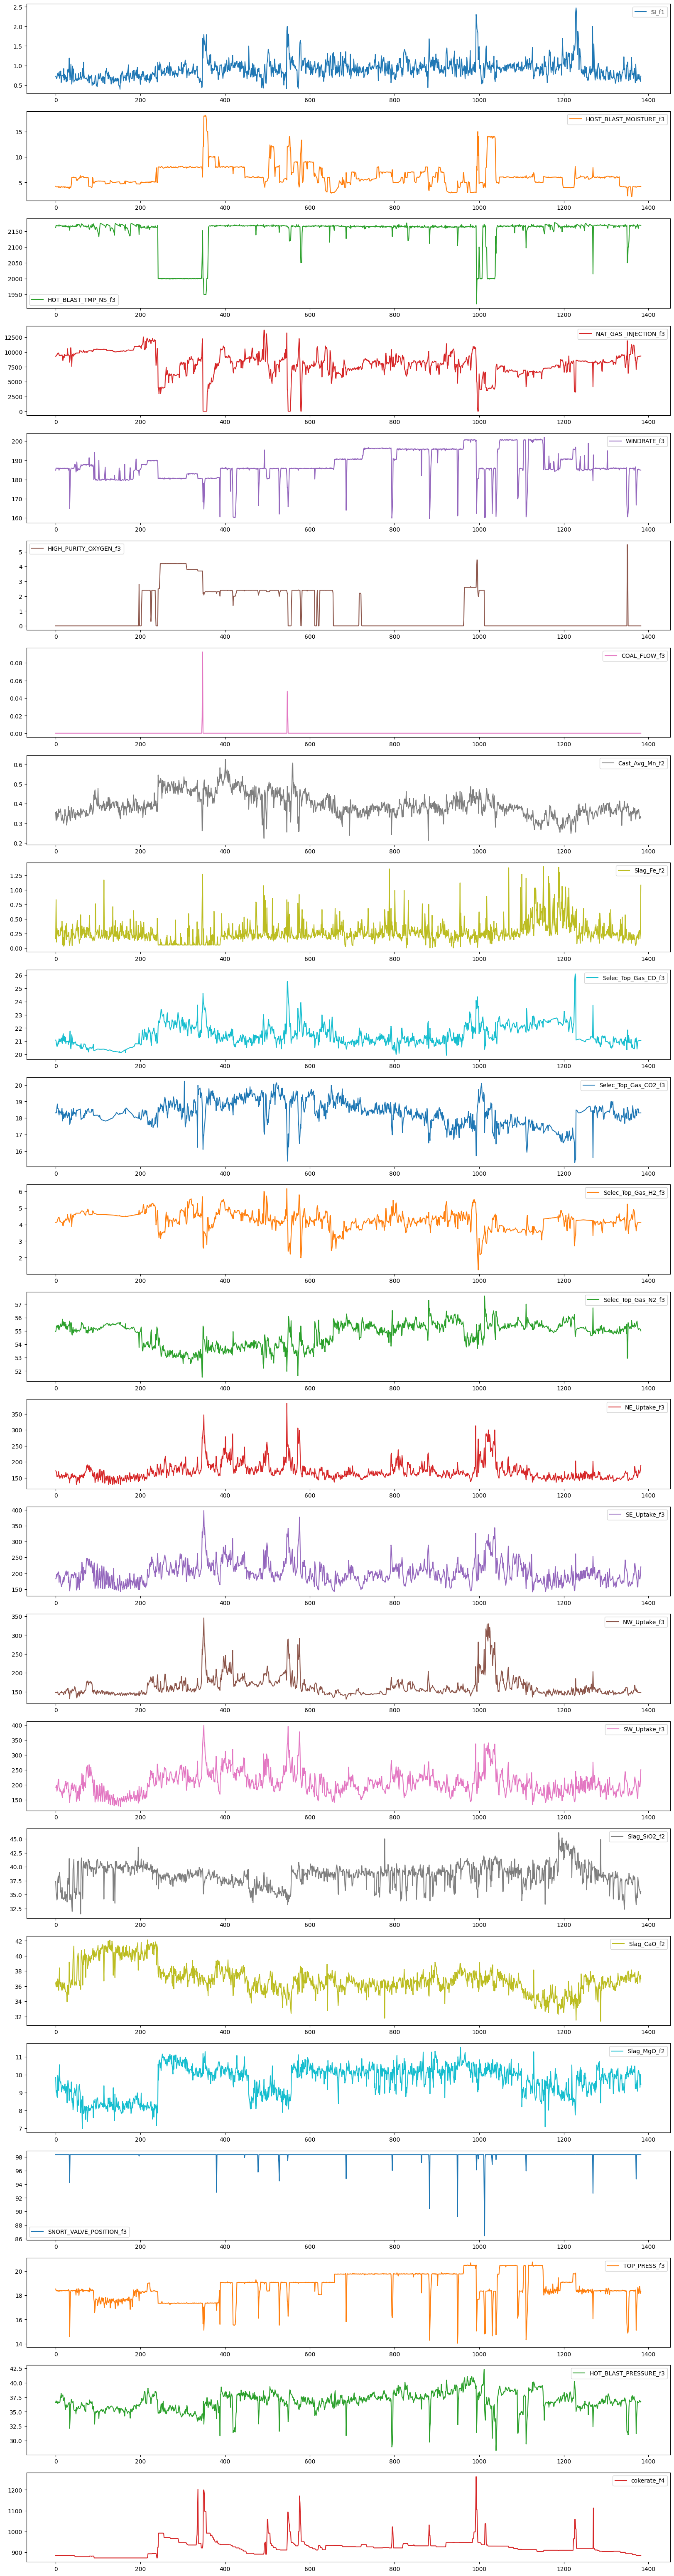

In [18]:

## layout=(4, 3), 
## style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r'],
## xticks=np.arange(0, len(df), 16)

## for_RNN_data_CIVS.plot( xticks=rc22, figsize=(20,80),  subplots=True   )

## x='MM_Timestamp_f1' ,

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [19]:

l_new


['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


## Back to the Data Processing


In [20]:

for_RNN_data_CIVS.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SI_f1                    1383 non-null   float64
 1   HOST_BLAST_MOISTURE_f3   1383 non-null   float64
 2   HOT_BLAST_TMP_NS_f3      1383 non-null   float64
 3   NAT_GAS _INJECTION_f3    1383 non-null   float64
 4   WINDRATE_f3              1383 non-null   float64
 5   HIGH_PURITY_OXYGEN_f3    1383 non-null   float64
 6   COAL_FLOW_f3             1383 non-null   float64
 7   Cast_Avg_Mn_f2           1383 non-null   float64
 8   Slag_Fe_f2               1383 non-null   float64
 9   Selec_Top_Gas_CO_f3      1383 non-null   float64
 10  Selec_Top_Gas_CO2_f3     1383 non-null   float64
 11  Selec_Top_Gas_H2_f3      1383 non-null   float64
 12  Selec_Top_Gas_N2_f3      1383 non-null   float64
 13  NE_Uptake_f3             1383 non-null   float64
 14  SE_Uptake_f3            

In [21]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Iterate and mark transitions


In [22]:
'''
for_RNN_data_CIVS.insert(       loc = 0,
                                column = 'control1',
                                value = 0)


for_RNN_data_CIVS.insert(       loc = 0,
                                column = 'control4',
                                value = 0)


for_RNN_data_CIVS.insert(       loc = 0,
                                column = 'control2',
                                value = 0)


for_RNN_data_CIVS.insert(       loc = 0,
                                column = 'control3',
                                value = 0)



for_RNN_data_CIVS
'''

"\nfor_RNN_data_CIVS.insert(       loc = 0,\n                                column = 'control1',\n                                value = 0)\n\n\nfor_RNN_data_CIVS.insert(       loc = 0,\n                                column = 'control4',\n                                value = 0)\n\n\nfor_RNN_data_CIVS.insert(       loc = 0,\n                                column = 'control2',\n                                value = 0)\n\n\nfor_RNN_data_CIVS.insert(       loc = 0,\n                                column = 'control3',\n                                value = 0)\n\n\n\nfor_RNN_data_CIVS\n"

In [23]:
'''
indeces_to_2500_control2 = []

indeces_to_2500 = [] 

counter_control2 = 0

counter = 500

prev_val = 0.0
    
for index, row in for_RNN_data_CIVS.iterrows():

    ## print( row["SI_f1"]  )
    #########################################################################
    if row["SI_f1"] == prev_val:
        for_RNN_data_CIVS.at[index, 'control1'] = counter
        counter = counter + 1
        indeces_to_2500.append( index )
    else:
        if counter > 2000:
            ## print(counter)
            ## input()
            for_RNN_data_CIVS["control4"][indeces_to_2500 ] = 1
            indeces_to_2500 = []
        else:
            indeces_to_2500 = []
        counter = 0

    ##########################################################################
    if row["SI_f1"] != prev_val:
        for_RNN_data_CIVS.at[index, 'control2'] = counter_control2
        counter_control2 = counter_control2 + 1
        indeces_to_2500_control2.append(  index  )
    else:
        if counter_control2 > 2000:
            ## print(counter)
            ## input()
            for_RNN_data_CIVS["control4"][indeces_to_2500_control2 ] = 1
            indeces_to_2500_control2 = []
        else:
            indeces_to_2500_control2 = []
        counter_control2 = 0

    ##########################################################################
    if row["SI_f1"] == prev_val:
        for_RNN_data_CIVS.at[index, 'control3'] = 1.0

    ##########################################################################
    if index  % 50000 == 0:
        print(index )
    prev_val = row["SI_f1"]
        
    
'''
    


'\nindeces_to_2500_control2 = []\n\nindeces_to_2500 = [] \n\ncounter_control2 = 0\n\ncounter = 500\n\nprev_val = 0.0\n    \nfor index, row in for_RNN_data_CIVS.iterrows():\n\n    ## print( row["SI_f1"]  )\n    #########################################################################\n    if row["SI_f1"] == prev_val:\n        for_RNN_data_CIVS.at[index, \'control1\'] = counter\n        counter = counter + 1\n        indeces_to_2500.append( index )\n    else:\n        if counter > 2000:\n            ## print(counter)\n            ## input()\n            for_RNN_data_CIVS["control4"][indeces_to_2500 ] = 1\n            indeces_to_2500 = []\n        else:\n            indeces_to_2500 = []\n        counter = 0\n\n    ##########################################################################\n    if row["SI_f1"] != prev_val:\n        for_RNN_data_CIVS.at[index, \'control2\'] = counter_control2\n        counter_control2 = counter_control2 + 1\n        indeces_to_2500_control2.append(  index  )

In [24]:
'''
## for_RNN_data_CIVS.plot(  figsize=(20,80),  subplots=True   )


for_RNN_data_CIVS.plot(x='MM_Timestamp_f1' , kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )
'''

"\n## for_RNN_data_CIVS.plot(  figsize=(20,80),  subplots=True   )\n\n\nfor_RNN_data_CIVS.plot(x='MM_Timestamp_f1' , kind='line', subplots=True, figsize=(20,80),\n        sharex=False, sharey=False, legend=True )\n"

In [25]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Drop row with value above x


In [26]:
'''
## for_RNN_data_CIVS = for_RNN_data_CIVS.drop( for_RNN_data_CIVS[ for_RNN_data_CIVS.control4 == 1 ].index ) ## , inplace = True)

for_RNN_data_CIVS = for_RNN_data_CIVS [ for_RNN_data_CIVS ["control4"] == 0].reset_index( drop=True )  ## this one
'''

'\n## for_RNN_data_CIVS = for_RNN_data_CIVS.drop( for_RNN_data_CIVS[ for_RNN_data_CIVS.control4 == 1 ].index ) ## , inplace = True)\n\nfor_RNN_data_CIVS = for_RNN_data_CIVS [ for_RNN_data_CIVS ["control4"] == 0].reset_index( drop=True )  ## this one\n'

In [27]:

## for_RNN_data_CIVS


In [28]:
'''
## for_RNN_data_CIVS.plot(  figsize=(20,80),  subplots=True   )

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )
'''

"\n## for_RNN_data_CIVS.plot(  figsize=(20,80),  subplots=True   )\n\nfor_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),\n        sharex=False, sharey=False, legend=True )\n"

In [29]:

for_RNN_data_CIVS.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SI_f1                    1383 non-null   float64
 1   HOST_BLAST_MOISTURE_f3   1383 non-null   float64
 2   HOT_BLAST_TMP_NS_f3      1383 non-null   float64
 3   NAT_GAS _INJECTION_f3    1383 non-null   float64
 4   WINDRATE_f3              1383 non-null   float64
 5   HIGH_PURITY_OXYGEN_f3    1383 non-null   float64
 6   COAL_FLOW_f3             1383 non-null   float64
 7   Cast_Avg_Mn_f2           1383 non-null   float64
 8   Slag_Fe_f2               1383 non-null   float64
 9   Selec_Top_Gas_CO_f3      1383 non-null   float64
 10  Selec_Top_Gas_CO2_f3     1383 non-null   float64
 11  Selec_Top_Gas_H2_f3      1383 non-null   float64
 12  Selec_Top_Gas_N2_f3      1383 non-null   float64
 13  NE_Uptake_f3             1383 non-null   float64
 14  SE_Uptake_f3            

In [30]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Average the rows to control time step



## Sanity check


In [31]:



data = [
[20 , 9,   15,  47],
[2,   50,  25,  26],
[4,   11,  38,  44],
[6,   33,  16,  25],
[8 ,  37,  27,  25],
[10,  28,  48,  32],
[12,  47,  35,  45],
[14,  8,   16,  7],
[16,  12,  16,  30],
[18 , 22,  39 , 29],
[20 , 9,   15,  47],
[20 , 9,   15,  47],
[2,   50,  25,  26],
[4,   11,  38,  44],
[6,   33,  16,  25],
[8 ,  37,  27,  25],
[10,  28,  48,  32],
[12,  47,  35,  45],
[14,  8,   16,  7],
[16,  12,  16,  30],
[18 , 22,  39 , 29],
[20 , 9,   15,  47],
[2,   50,  25,  26],
[4,   11,  38,  44],
[6,   33,  16,  25],
[8 ,  37,  27,  25],
[10,  28,  48,  32],
[12,  47,  35,  45],
[14,  8,   16,  7],
[16,  12,  16,  30]
]



df_example = pd.DataFrame( data, columns=['a', 'b', 'c', 'd'] )
 

print(df_example)


     a   b   c   d
0   20   9  15  47
1    2  50  25  26
2    4  11  38  44
3    6  33  16  25
4    8  37  27  25
5   10  28  48  32
6   12  47  35  45
7   14   8  16   7
8   16  12  16  30
9   18  22  39  29
10  20   9  15  47
11  20   9  15  47
12   2  50  25  26
13   4  11  38  44
14   6  33  16  25
15   8  37  27  25
16  10  28  48  32
17  12  47  35  45
18  14   8  16   7
19  16  12  16  30
20  18  22  39  29
21  20   9  15  47
22   2  50  25  26
23   4  11  38  44
24   6  33  16  25
25   8  37  27  25
26  10  28  48  32
27  12  47  35  45
28  14   8  16   7
29  16  12  16  30


In [32]:

print(df_example.shape)


(30, 4)


In [33]:

## avg_df_example = df_example.groupby(np.arange(len(df_example))//avg_the_rows_parameter).mean()
## avg_df_example.shape


In [34]:

## avg_df_example



## Now Avg to change time step


In [35]:

## for_RNN_data_CIVS

print(for_RNN_data_CIVS.shape)


(1383, 24)


In [36]:
'''
for_RNN_data_CIVS = for_RNN_data_CIVS.groupby(np.arange(len(for_RNN_data_CIVS))//avg_the_rows_parameter).mean()
for_RNN_data_CIVS.shape
'''

'\nfor_RNN_data_CIVS = for_RNN_data_CIVS.groupby(np.arange(len(for_RNN_data_CIVS))//avg_the_rows_parameter).mean()\nfor_RNN_data_CIVS.shape\n'

In [37]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Create datasets of selected features


In [38]:

pd.options.display.max_columns = None


In [39]:

def window_seq_conversion_multi_feature(df, window, target_index):
    d = df.values
    ## print( d )
    print( d.shape )
    x = []
    n = len(df)
    n_features = df.shape[1]
    ## print(n_features)
    ## print(n)

    idx = df.index[ : -window]
    print(idx)
    print(  idx.shape  )


    for start in range(n-window):
        end = start + window
        ## print(start, "....", end)
        x.append( d[ start:end, : ] )

    ## print(x)
    cols_x = [ f'xt_{i}_fx_{j}' for i in range(1, window+1) for j in range(0, n_features)]
    cols_y = [ f'y_fy_{j}' for j in range(0, n_features)]
    ## print(  cols  )

    x = np.array(x)
    print(x.shape)
    x = np.array(x).reshape(n-window, -1)
    print(x.shape)

    y = df.iloc[ window: , : ].values
    print( y.shape )
    ## print( y.reshape(-1).shape )

    df_xs = pd.DataFrame(x  , columns=cols_x,  index=idx)
    df_y  = pd.DataFrame(y  , columns=cols_y,  index=idx)
    ## print(df_y)
    return pd.concat( [df_xs, df_y], axis=1 )



## Make Data Sequential


In [40]:

 
res_multi_feature_df = window_seq_conversion_multi_feature( for_RNN_data_CIVS, window,  silicon_feature_index )


(1383, 24)
RangeIndex(start=0, stop=1378, step=1)
(1378,)
(1378, 5, 24)
(1378, 120)
(1378, 24)


In [41]:

res_multi_feature_df


xt_1_fx_0  xt_1_fx_1    xt_1_fx_2    xt_1_fx_3   xt_1_fx_4  xt_1_fx_5  \
0      0.719500   4.242439  2161.425209  9306.840913  184.818611        0.0   
1      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
2      0.666106   4.126144  2167.779119  9419.200115  185.828474        0.0   
3      0.675145   4.120736  2166.974740  9564.165802  185.924481        0.0   
4      0.776831   4.120331  2166.384674  9648.247637  185.942943        0.0   
...         ...        ...          ...          ...         ...        ...   
1373   0.625000   4.142208  2166.999631  8604.508731  180.473741        0.0   
1374   0.656000   4.204565  2171.080200  8948.966890  185.189185        0.0   
1375   0.768250   4.180426  2165.672336  9250.708262  184.902734        0.0   
1376   0.762333   4.185938  2158.690664  9233.896469  185.425250        0.0   
1377   0.653000   4.193129  2166.798490  9227.040194  185.068165        0.0   

      xt_1_fx_6  xt_1_fx_7  xt_1_fx_8  xt_1_fx_9  xt_1_fx_10  xt_1_fx_11  \
0           0.0      0.354       0.16  21.080431   18.313322    4.131228   
1           0.0      0.313       0.83  20.996415   18.311768    4.133911   
2           0.0      0.360       0.10  20.749627   18.341701    4.137632   
3           0.0      0.319       0.34  20.609259   18.644476    4.142824   
4           0.0      0.335       0.28  20.617383   18.845791    4.220690   
...         ...        ...        ...        ...         ...         ...   
1373        0.0      0.346       0.21  20.400904   18.543402    3.999111   
1374        0.0      0.367       0.18  20.711381   18.524072    4.030703   
1375        0.0      0.352       0.23  21.006446   18.555817    4.128073   
1376        0.0      0.369       0.15  21.019711   18.545295    4.128638   
1377        0.0      0.371       0.26  21.027439   18.306710    4.128967   

      xt_1_fx_12  xt_1_fx_13  xt_1_fx_14  xt_1_fx_15  xt_1_fx_16  xt_1_fx_17  \
0      54.940123  171.769513  182.533770  148.126483  192.512412   37.369999   
1      55.072779  170.595469  183.725050  148.161842  192.366046   35.540001   
2      55.375043  167.017421  195.812061  147.562523  198.423474   34.849998   
3      55.341884  154.214917  188.028883  147.807509  179.116839   34.009998   
4      55.284451  156.234542  200.141261  149.014319  186.052137   34.380001   
...          ...         ...         ...         ...         ...         ...   
1373   55.737930  160.269405  176.758759  153.697897  172.798802   35.279999   
1374   55.366068  150.720774  157.351473  151.373892  154.779708   34.389999   
1375   55.253905  153.110712  156.348255  148.084920  159.371105   38.119999   
1376   55.111536  168.325562  198.804627  148.092364  211.545443   37.230000   
1377   55.144316  174.761601  210.053446  148.096707  213.421269   36.680000   

      xt_1_fx_18  xt_1_fx_19  xt_1_fx_20  xt_1_fx_21  xt_1_fx_22  xt_1_fx_23  \
0      36.439999        9.86   98.334297   18.532928   36.602600       884.0   
1      35.970001        9.03   98.334297   18.397217   36.882963       884.0   
2      36.590000        9.13   98.334297   18.393974   36.568884       884.0   
3      35.900002        8.82   98.334297   18.370316   36.839147       884.0   
4      35.970001        8.73   98.334297   18.395860   36.658018       884.0   
...          ...         ...         ...         ...         ...         ...   
1373   37.160000        9.69   98.334297   17.645761   35.344274       884.0   
1374   36.340000        9.08   98.334297   18.436046   36.811064       884.0   
1375   37.270000        9.90   98.334297   18.661701   36.583388       884.0   
1376   37.930000       10.24   98.334297   18.460356   36.612843       884.0   
1377   37.650002       10.23   98.334297   18.152570   36.607580       884.0   

      xt_2_fx_0  xt_2_fx_1    xt_2_fx_2    xt_2_fx_3   xt_2_fx_4  xt_2_fx_5  \
0      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
1      0.666106   4.126144  2167.779119  9419.200115  185.828474

In [42]:

print( res_multi_feature_df.shape )


(1378, 144)



## Drop desired columns from Sequential Data Frame (such as silicon from X)


In [43]:

'''

df = res_multi_feature_df

df.drop(  list(   df.filter(regex='_fx_0')   ), axis=1, inplace=True)

no_silicon_in_seq_X_df = df

print( df.shape )

'''


"\n\ndf = res_multi_feature_df\n\ndf.drop(  list(   df.filter(regex='_fx_0')   ), axis=1, inplace=True)\n\nno_silicon_in_seq_X_df = df\n\nprint( df.shape )\n\n"

In [44]:

print( res_multi_feature_df.shape )


(1378, 144)


In [45]:

res_multi_feature_df


xt_1_fx_0  xt_1_fx_1    xt_1_fx_2    xt_1_fx_3   xt_1_fx_4  xt_1_fx_5  \
0      0.719500   4.242439  2161.425209  9306.840913  184.818611        0.0   
1      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
2      0.666106   4.126144  2167.779119  9419.200115  185.828474        0.0   
3      0.675145   4.120736  2166.974740  9564.165802  185.924481        0.0   
4      0.776831   4.120331  2166.384674  9648.247637  185.942943        0.0   
...         ...        ...          ...          ...         ...        ...   
1373   0.625000   4.142208  2166.999631  8604.508731  180.473741        0.0   
1374   0.656000   4.204565  2171.080200  8948.966890  185.189185        0.0   
1375   0.768250   4.180426  2165.672336  9250.708262  184.902734        0.0   
1376   0.762333   4.185938  2158.690664  9233.896469  185.425250        0.0   
1377   0.653000   4.193129  2166.798490  9227.040194  185.068165        0.0   

      xt_1_fx_6  xt_1_fx_7  xt_1_fx_8  xt_1_fx_9  xt_1_fx_10  xt_1_fx_11  \
0           0.0      0.354       0.16  21.080431   18.313322    4.131228   
1           0.0      0.313       0.83  20.996415   18.311768    4.133911   
2           0.0      0.360       0.10  20.749627   18.341701    4.137632   
3           0.0      0.319       0.34  20.609259   18.644476    4.142824   
4           0.0      0.335       0.28  20.617383   18.845791    4.220690   
...         ...        ...        ...        ...         ...         ...   
1373        0.0      0.346       0.21  20.400904   18.543402    3.999111   
1374        0.0      0.367       0.18  20.711381   18.524072    4.030703   
1375        0.0      0.352       0.23  21.006446   18.555817    4.128073   
1376        0.0      0.369       0.15  21.019711   18.545295    4.128638   
1377        0.0      0.371       0.26  21.027439   18.306710    4.128967   

      xt_1_fx_12  xt_1_fx_13  xt_1_fx_14  xt_1_fx_15  xt_1_fx_16  xt_1_fx_17  \
0      54.940123  171.769513  182.533770  148.126483  192.512412   37.369999   
1      55.072779  170.595469  183.725050  148.161842  192.366046   35.540001   
2      55.375043  167.017421  195.812061  147.562523  198.423474   34.849998   
3      55.341884  154.214917  188.028883  147.807509  179.116839   34.009998   
4      55.284451  156.234542  200.141261  149.014319  186.052137   34.380001   
...          ...         ...         ...         ...         ...         ...   
1373   55.737930  160.269405  176.758759  153.697897  172.798802   35.279999   
1374   55.366068  150.720774  157.351473  151.373892  154.779708   34.389999   
1375   55.253905  153.110712  156.348255  148.084920  159.371105   38.119999   
1376   55.111536  168.325562  198.804627  148.092364  211.545443   37.230000   
1377   55.144316  174.761601  210.053446  148.096707  213.421269   36.680000   

      xt_1_fx_18  xt_1_fx_19  xt_1_fx_20  xt_1_fx_21  xt_1_fx_22  xt_1_fx_23  \
0      36.439999        9.86   98.334297   18.532928   36.602600       884.0   
1      35.970001        9.03   98.334297   18.397217   36.882963       884.0   
2      36.590000        9.13   98.334297   18.393974   36.568884       884.0   
3      35.900002        8.82   98.334297   18.370316   36.839147       884.0   
4      35.970001        8.73   98.334297   18.395860   36.658018       884.0   
...          ...         ...         ...         ...         ...         ...   
1373   37.160000        9.69   98.334297   17.645761   35.344274       884.0   
1374   36.340000        9.08   98.334297   18.436046   36.811064       884.0   
1375   37.270000        9.90   98.334297   18.661701   36.583388       884.0   
1376   37.930000       10.24   98.334297   18.460356   36.612843       884.0   
1377   37.650002       10.23   98.334297   18.152570   36.607580       884.0   

      xt_2_fx_0  xt_2_fx_1    xt_2_fx_2    xt_2_fx_3   xt_2_fx_4  xt_2_fx_5  \
0      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
1      0.666106   4.126144  2167.779119  9419.200115  185.828474


## Drop last in X input sequence

* predict the one not seen , i think




In [46]:

window_str = str(window)
window_str


'5'

In [47]:

string_match_last_seq = "xt_" + window_str
string_match_last_seq 


'xt_5'

In [48]:

'''

df = res_multi_feature_df

df.drop(  list(   df.filter(regex=string_match_last_seq)   ), axis=1, inplace=True)

no_silicon_in_seq_X_df = df

print( df.shape )

'''


'\n\ndf = res_multi_feature_df\n\ndf.drop(  list(   df.filter(regex=string_match_last_seq)   ), axis=1, inplace=True)\n\nno_silicon_in_seq_X_df = df\n\nprint( df.shape )\n\n'

In [49]:

print( res_multi_feature_df.shape )


(1378, 144)


In [50]:

res_multi_feature_df


xt_1_fx_0  xt_1_fx_1    xt_1_fx_2    xt_1_fx_3   xt_1_fx_4  xt_1_fx_5  \
0      0.719500   4.242439  2161.425209  9306.840913  184.818611        0.0   
1      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
2      0.666106   4.126144  2167.779119  9419.200115  185.828474        0.0   
3      0.675145   4.120736  2166.974740  9564.165802  185.924481        0.0   
4      0.776831   4.120331  2166.384674  9648.247637  185.942943        0.0   
...         ...        ...          ...          ...         ...        ...   
1373   0.625000   4.142208  2166.999631  8604.508731  180.473741        0.0   
1374   0.656000   4.204565  2171.080200  8948.966890  185.189185        0.0   
1375   0.768250   4.180426  2165.672336  9250.708262  184.902734        0.0   
1376   0.762333   4.185938  2158.690664  9233.896469  185.425250        0.0   
1377   0.653000   4.193129  2166.798490  9227.040194  185.068165        0.0   

      xt_1_fx_6  xt_1_fx_7  xt_1_fx_8  xt_1_fx_9  xt_1_fx_10  xt_1_fx_11  \
0           0.0      0.354       0.16  21.080431   18.313322    4.131228   
1           0.0      0.313       0.83  20.996415   18.311768    4.133911   
2           0.0      0.360       0.10  20.749627   18.341701    4.137632   
3           0.0      0.319       0.34  20.609259   18.644476    4.142824   
4           0.0      0.335       0.28  20.617383   18.845791    4.220690   
...         ...        ...        ...        ...         ...         ...   
1373        0.0      0.346       0.21  20.400904   18.543402    3.999111   
1374        0.0      0.367       0.18  20.711381   18.524072    4.030703   
1375        0.0      0.352       0.23  21.006446   18.555817    4.128073   
1376        0.0      0.369       0.15  21.019711   18.545295    4.128638   
1377        0.0      0.371       0.26  21.027439   18.306710    4.128967   

      xt_1_fx_12  xt_1_fx_13  xt_1_fx_14  xt_1_fx_15  xt_1_fx_16  xt_1_fx_17  \
0      54.940123  171.769513  182.533770  148.126483  192.512412   37.369999   
1      55.072779  170.595469  183.725050  148.161842  192.366046   35.540001   
2      55.375043  167.017421  195.812061  147.562523  198.423474   34.849998   
3      55.341884  154.214917  188.028883  147.807509  179.116839   34.009998   
4      55.284451  156.234542  200.141261  149.014319  186.052137   34.380001   
...          ...         ...         ...         ...         ...         ...   
1373   55.737930  160.269405  176.758759  153.697897  172.798802   35.279999   
1374   55.366068  150.720774  157.351473  151.373892  154.779708   34.389999   
1375   55.253905  153.110712  156.348255  148.084920  159.371105   38.119999   
1376   55.111536  168.325562  198.804627  148.092364  211.545443   37.230000   
1377   55.144316  174.761601  210.053446  148.096707  213.421269   36.680000   

      xt_1_fx_18  xt_1_fx_19  xt_1_fx_20  xt_1_fx_21  xt_1_fx_22  xt_1_fx_23  \
0      36.439999        9.86   98.334297   18.532928   36.602600       884.0   
1      35.970001        9.03   98.334297   18.397217   36.882963       884.0   
2      36.590000        9.13   98.334297   18.393974   36.568884       884.0   
3      35.900002        8.82   98.334297   18.370316   36.839147       884.0   
4      35.970001        8.73   98.334297   18.395860   36.658018       884.0   
...          ...         ...         ...         ...         ...         ...   
1373   37.160000        9.69   98.334297   17.645761   35.344274       884.0   
1374   36.340000        9.08   98.334297   18.436046   36.811064       884.0   
1375   37.270000        9.90   98.334297   18.661701   36.583388       884.0   
1376   37.930000       10.24   98.334297   18.460356   36.612843       884.0   
1377   37.650002       10.23   98.334297   18.152570   36.607580       884.0   

      xt_2_fx_0  xt_2_fx_1    xt_2_fx_2    xt_2_fx_3   xt_2_fx_4  xt_2_fx_5  \
0      0.710486   4.174343  2168.238915  9336.364456  185.993447        0.0   
1      0.666106   4.126144  2167.779119  9419.200115  185.828474


## Need to adjust windows based on previous step


In [51]:


## window = window - 1



In [52]:


window


5


## Utility Functions


In [53]:

class Standardize:
    
    def __init__(self, df, split=0.10):
        self.data  = df
        self.split = split
    
    def split_data(self):
        n           = int( len( self.data ) * self.split )
        train       = self.data.iloc[   :-n ] 
        test        = self.data.iloc[ -n:   ]
        n           = int( len(   train   ) * self.split  * 0.30 )
        train       = train.iloc[   :-n ] 
        val         = train.iloc[ -n:   ]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = ( data - self.mu ) / self.sigma          
        return data_s
    
    def fit_transform(self):
        train, test, val    = self.split_data()
        self.mu             = train.mean() 
        self.sigma          = train.std()
        train_s             = self._transform( train )
        test_s              = self._transform( test  )
        val_s               = self._transform( val   )
        return train_s, test_s, val_s
    
    def inverse(self,   data):
        return ( data * self.sigma     ) + self.mu          ## all data
        
    def inverse_y(self, data):
        print(self.sigma.shape)
        print(self.mu.shape)
        print(self.mu[-vector_n_out:].shape)
        print(self.sigma[-vector_n_out:].shape)
        print(data.shape)
        the_sigma = self.sigma[-vector_n_out:]
        the_mu    = self.mu[-vector_n_out:]

        the_sigma = np.expand_dims(the_sigma, axis=0)
        the_mu    = np.expand_dims(the_mu,    axis=0)

        print(the_sigma.shape)
        print(the_sigma.shape)
        
        return ( data * the_sigma ) + the_mu       


In [54]:

scale_civs = Standardize(  res_multi_feature_df , split=0.20 )


In [55]:

train_si, test_si, val_si = scale_civs.fit_transform()


In [56]:

train_si


xt_1_fx_0  xt_1_fx_1  xt_1_fx_2  xt_1_fx_3  xt_1_fx_4  xt_1_fx_5  \
0     -0.765070  -0.946087   0.367938   0.508422  -0.277023  -0.877953   
1     -0.804595  -0.974470   0.483340   0.521621  -0.114281  -0.877953   
2     -0.999187  -0.994560   0.475552   0.558654  -0.137134  -0.877953   
3     -0.959551  -0.996814   0.461929   0.623463  -0.123835  -0.877953   
4     -0.513691  -0.996982   0.451935   0.661053  -0.121277  -0.877953   
...         ...        ...        ...        ...        ...        ...   
1032   0.298215   3.071553  -2.362933  -1.802725  -2.148233  -0.877953   
1033   0.747521   3.157352  -2.372659  -1.860206  -0.960461  -0.877953   
1034   0.157458   3.062492  -2.366020  -1.937901  -0.225039  -0.877953   
1035   1.502424   3.130700  -2.366273  -1.967426  -0.134156  -0.877953   
1036  -0.975677   3.111488  -2.377855  -1.983979  -0.101983  -0.877953   

      xt_1_fx_6  xt_1_fx_7  xt_1_fx_8  xt_1_fx_9  xt_1_fx_10  xt_1_fx_11  \
0     -0.052398  -0.960257  -0.503719  -0.343504   -0.231716   -0.320565   
1     -0.052398  -1.679288   3.737418  -0.452344   -0.234001   -0.315946   
2     -0.052398  -0.855033  -0.883522  -0.772046   -0.189993   -0.309543   
3     -0.052398  -1.574064   0.635691  -0.953886    0.255152   -0.300608   
4     -0.052398  -1.293467   0.255888  -0.943362    0.551127   -0.166609   
...         ...        ...        ...        ...         ...         ...   
1032  -0.052398   0.530416  -0.693620  -0.397428   -2.029451    0.125323   
1033  -0.052398   0.723326   0.445790  -0.352489   -1.968746   -0.057705   
1034  -0.052398  -0.556899   0.255888  -0.256601   -2.284965   -0.001944   
1035  -0.052398   0.232281   1.395298  -0.308896   -2.168084    0.195140   
1036  -0.052398   0.547953  -0.503719   0.471991   -2.506754    0.415249   

      xt_1_fx_12  xt_1_fx_13  xt_1_fx_14  xt_1_fx_15  xt_1_fx_16  xt_1_fx_17  \
0       0.341086   -0.096807   -0.632599   -0.604631   -0.446477   -0.511305   
1       0.483152   -0.136336   -0.599250   -0.603457   -0.450034   -1.526451   
2       0.806859   -0.256806   -0.260887   -0.623357   -0.302823   -1.909213   
3       0.771347   -0.687856   -0.478769   -0.615223   -0.772022   -2.375182   
4       0.709840   -0.619857   -0.139696   -0.575150   -0.603477   -2.169932   
...          ...         ...         ...         ...         ...         ...   
1032    1.733522    1.402433    1.599596    1.750912    1.439950    0.537125   
1033    1.739902    2.610047    2.729552    2.463545    2.499200    1.463517   
1034    2.014415    2.988925    3.125247    3.174386    2.639661    1.147324   
1035    1.830546    2.980630    2.875438    3.276723    2.528186    1.707595   
1036    1.468260    2.625530    2.943540    2.716539    2.227578    1.629934   

      xt_1_fx_18  xt_1_fx_19  xt_1_fx_20  xt_1_fx_21  xt_1_fx_22  xt_1_fx_23  \
0      -0.491922    0.180109    0.104798   -0.114819   -0.083390   -0.970913   
1      -0.755968   -0.734099    0.104798   -0.239510    0.087380   -0.970913   
2      -0.407651   -0.623953    0.104798   -0.242490   -0.103927   -0.970913   
3      -0.795294   -0.965404    0.104798   -0.264226    0.060692   -0.970913   
4      -0.755968   -1.064536    0.104798   -0.240757   -0.049635   -0.970913   
...          ...         ...         ...         ...         ...         ...   
1032    0.845169    1.270551    0.104798   -2.102920   -2.345870    0.083683   
1033   -0.727878    0.675765    0.104798   -0.995531   -1.850789    0.083683   
1034   -0.357089    0.521561    0.104798   -0.329971   -0.716044    0.083683   
1035   -1.070578    0.433445    0.104798   -0.281014   -0.437987    0.083683   
1036   -0.351471    0.929100    0.104798   -0.284453   -0.306786    0.083683   

      xt_2_fx_0  xt_2_fx_1  xt_2_fx_2  xt_2_fx_3  xt_2_fx_4  xt_2_fx_5  \
0     -0.804059  -0.974276   0.484702   0.523099  -0.114375  -0.877953   
1     -0.998596  -0.994281   0.476935   0.560072  -0.137228  -0.877953   
2     -0.958971  -0.996526   0.463347   0.624775  -0.123928 


## Some Sanity Checks


In [57]:

print( scale_civs.split)


0.2


In [58]:

print(f'''
SI: train: { len(train_si) } , val:{ len(val_si) }, test: { len(test_si) } 
''')



SI: train: 1037 , val:66, test: 275 



In [59]:

numpy_array = train_si.values
type(numpy_array)


numpy.ndarray

In [60]:

torch_tensor = torch.from_numpy(numpy_array)
type(torch_tensor)


torch.Tensor

In [61]:

from_torch_to_numpy = torch_tensor.detach().numpy()
type(from_torch_to_numpy)


numpy.ndarray


## Convert to Torch tensors Option 1


In [62]:


def Convert_to_RNN_tensors( list_data_civs ):
    
    y=[torch.from_numpy(col.iloc[ :,  -vector_n_out: ].values.reshape(-1, vector_n_out)   ).float()   for col in list_data_civs]
    x=[torch.from_numpy(col.iloc[ :, :-vector_n_out].values.reshape(*col.iloc[ :, :-vector_n_out].shape)).float() for col in list_data_civs]
    
    return y, x


In [63]:

list_data_civs = [ train_si, val_si, test_si ]

y, x           = Convert_to_RNN_tensors(   list_data_civs  )


In [64]:

y_train_si = y[0]
y_val_si   = y[1]
y_test_si  = y[2]
x_train_si = x[0]
x_val_si   = x[1]
x_test_si  = x[2]


In [65]:

print( y_train_si.shape )
print(   y_val_si.shape ) 
print(  y_test_si.shape ) 
print( x_train_si.shape )
print(   x_val_si.shape )
print(  x_test_si.shape )


torch.Size([1037, 24])
torch.Size([66, 24])
torch.Size([275, 24])
torch.Size([1037, 120])
torch.Size([66, 120])
torch.Size([275, 120])



## Parameters (set these manually)


In [66]:

vector_n_out


24

In [67]:

params_si = {
'seq_length': window,       ## this is the window
'input_size': vector_n_out, ## 18,  ## 4,      ## x input size -> my_4_cols = [  'SI_f1', 'HM_Temp_f1', 'Slag_CaO_f2', 'C_perce_sat_f1' ]
'output_size':vector_n_out,
'units': 64,         ## 32,                 ## neurons in hidden layers
'n_layers':1,
'epochs': 3000,
'print_every': 25,
'lr':  0.01,      ## 0.001
'train_data': (x_train_si, y_train_si),
'val_data':     (x_val_si, y_val_si),
'test_data':   (x_test_si, y_test_si),
'idx': test_si.index,                        ## needed for validation, use test set here
'scale': scale_civs
}



plt.rcParams["figure.figsize"] = [14, 5] 


In [68]:

test_si.index


RangeIndex(start=1103, stop=1378, step=1)


## Training Function



In [69]:

def myKL_loss():
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    input = F.log_softmax(torch.randn(3, 5, requires_grad=True), dim=1)

    target = F.softmax(torch.rand(3, 5), dim=1)
    output = kl_loss(input, target)


In [70]:

def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['seq_length'],
                    kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['seq_length'],
                     kwargs['input_size'], 
                     kwargs['output_size'], 
                     kwargs['units'], 
                     kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['seq_length'],
                      kwargs['input_size'], 
                      kwargs['output_size'], 
                      kwargs['units'], 
                      kwargs['n_layers'])

    criterion       = nn.MSELoss()
    criterion_mse   = nn.MSELoss()

    criterion_l1    = nn.L1Loss()
    criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'], weight_decay=0.0005)
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val     = kwargs['val_data']
    x_test, y_test   = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs      = kwargs['epochs']
    print_every = kwargs['print_every']

    ## epochs = 200
    
    for batch_i, epoch in enumerate(range(epochs)):

        
        h = model.init_hidden( x_train.shape[0])
        optimizer.zero_grad()
        
        pred, h = model( x_train, h )   #model(x_train)
        #hidden = hidden.data

        ## print(pred.shape)
        ## print(y_train.shape)

        input_kl  = F.log_softmax(y_train, dim=1)
        target_kl = F.softmax(pred, dim=1)
        
        ## loss = criterion_kl(input_kl, target_kl)
        l1_lambda = 0.001
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        ## loss    = criterion_kl(input_kl, target_kl)  + l1_lambda*l1_norm  

        loss =  criterion_l1( pred, y_train ) 
        
        ## loss = criterion_l1( pred, y_train ) + criterion_kl(input_kl, target_kl)
        
        loss.backward()
        optimizer.step()
        
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h        = model.init_hidden( x_val.shape[0] )
                val_p, val_h = model(x_val, val_h)
                val_loss     = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0    = model.init_hidden( x_test.shape[0] )
        y_hat = model(x_test, h0)
        
    y_hat, _ = y_hat
    mse_loss_air = criterion_mse(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--',   label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    print("ricardo check this")
    print(y_test.shape)
    print(y_hat.shape )
    actual = scale.inverse_y(y_test.detach().numpy() ) ## .ravel() )
    pred   = scale.inverse_y( y_hat.detach().numpy() ) ## .ravel() )
    idx = kwargs['idx']
    ##pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65, color='blue')
    ##pd.Series(pred,   index=idx).plot(style='k',   label='forecast' , color='red')
    print(actual.shape)
    print(pred.shape)
    actual = actual[:, 0]
    pred   =   pred[:, 0]
    pd.Series(actual, index=idx).plot( label='actual',    color='blue')
    pd.Series(pred,   index=idx).plot( label='forecast' , color='red' )
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history



## Inference Utility functions


In [71]:

def bins_inference_model_pt(model, x_test, y_test ):

    model_type='RNN'

    n_test = x_test.shape[0]

    list_real_si = []
    list_pred_si = []

    input_test_x = 0

    for i in range( n_test ):

        if i == 0:
            input_test_x = x_test[i]    
            input_test_x = input_test_x.unsqueeze(0)

        if i % 10000 == 0:
            print(i)
        
        model.eval()
        with torch.no_grad():
            h0       = model.init_hidden( 1 )
            
            y_pred, h0 = model( input_test_x , h0 )
           
            
            temp_x_test = input_test_x[:, vector_n_out:]   ## 19 if si included, 18 if si not included 
            
            concat_part = y_pred[:, 0:]       ## 0 if si in x, 1 if si not in x
            new_x_test = torch.cat((temp_x_test , concat_part), 1)
            
            
            input_test_x = new_x_test
            
            
            y_pred_si     = y_pred[:, 0].detach().numpy() 
            y_real_si     = y_test[i, 0].detach().numpy() 


            the_sigma = scale_civs.sigma[-vector_n_out]
            the_mu    = scale_civs.mu[-vector_n_out]

            y_pred_si = (y_pred_si * the_sigma) + the_mu 
            y_real_si = (y_real_si * the_sigma) + the_mu 

            list_real_si.append(y_real_si )
            list_pred_si.append(y_pred_si)

    l_real = list_real_si
    l_pred = list_pred_si

    eval_criterion = nn.MSELoss()
    ## torch.FloatTensor(a)
    mse_eval_bins = eval_criterion(torch.FloatTensor(l_pred), torch.FloatTensor( l_real))
    print(f'Test MSE Loss: {mse_eval_bins.item():.4f}')
 
    x = [ i for i in range(len(l_real)) ] 
    print(len(x))
  
    # plot lines 

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    
    plt.legend() 
    plt.show()

## return list_real_si, list_pred_si
            


In [72]:


def inference_model_pt_2(model, model_type='RNN', **kwargs):
    ''' 
    if model_type=='RNN':
        model = RNN(kwargs['seq_length'],
                    kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['seq_length'],
                     kwargs['input_size'], 
                     kwargs['output_size'], 
                     kwargs['units'], 
                     kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['seq_length'],
                      kwargs['input_size'], 
                      kwargs['output_size'], 
                      kwargs['units'], 
                      kwargs['n_layers'])
        
    '''
    
    x_test, y_test   = kwargs['test_data']
    n_test = x_test.shape[0]

    list_real_si = []
    list_pred_si = []

    input_test_x = 0

    ## h0       = model.init_hidden( 1 )
    
    for i in range( n_test ):

        ## if i == 0:
        input_test_x = x_test[i]    ## [1, 30x18]
        input_test_x = input_test_x.unsqueeze(0)

        if i % 10000 == 0:
            print(i)
        
        model.eval()
        with torch.no_grad():
            h0       = model.init_hidden( 1 )
          
            y_pred, h0 = model( input_test_x , h0 )
           
            
      
            y_pred_si     = y_pred[:, 0].detach().numpy() 

            y_real_si     = y_test[i, 0].detach().numpy() 

     

            the_sigma = scale_civs.sigma[-vector_n_out]
            the_mu    = scale_civs.mu[-vector_n_out]

            y_pred_si = (y_pred_si * the_sigma) + the_mu 
            y_real_si = (y_real_si * the_sigma) + the_mu 

            list_real_si.append(y_real_si )
            list_pred_si.append(y_pred_si)

    return list_real_si, list_pred_si
            
        



In [73]:

def inference_model_pt(model, model_type='RNN', **kwargs):

    
    x_test, y_test   = kwargs['test_data']
    n_test = x_test.shape[0]

    list_real_si = []
    list_pred_si = []

    input_test_x = 0

    ## h0       = model.init_hidden( 1 )
    
    for i in range( n_test ):

        if i == 0:
            input_test_x = x_test[i]    ## [1, 30x18]
            input_test_x = input_test_x.unsqueeze(0)

        if i % 10000 == 0:
            print(i)
        
        model.eval()
        with torch.no_grad():
            h0       = model.init_hidden( 1 )
           
            y_pred, h0 = model( input_test_x , h0 )
          

            
            temp_x_test = input_test_x[:, vector_n_out:]
         
            concat_part = y_pred[:, 0:]
           
            new_x_test = torch.cat((temp_x_test , concat_part), 1)
          
            
            
            input_test_x = new_x_test
            
            
            y_pred_si     = y_pred[:, 0].detach().numpy() 

            y_real_si     = y_test[i, 0].detach().numpy() 

        

            the_sigma = scale_civs.sigma[-vector_n_out]
            the_mu    = scale_civs.mu[-vector_n_out]

            y_pred_si = (y_pred_si * the_sigma) + the_mu 
            y_real_si = (y_real_si * the_sigma) + the_mu 

            list_real_si.append(y_real_si )
            list_pred_si.append(y_pred_si)

    return list_real_si, list_pred_si
            
        



## Normal RNN


In [74]:

class SelfAttentionLayer(nn.Module):
    def __init__(self, feature_size):
        super(SelfAttentionLayer, self).__init__()
        self.feature_size = feature_size

        # Linear transformations for Q, K, V from the same source
        self.key = nn.Linear(feature_size, feature_size)
        self.query = nn.Linear(feature_size, feature_size)
        self.value = nn.Linear(feature_size, feature_size)

    def forward(self, x, mask=None):
        # Apply linear transformations
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)

        # Scaled dot-product attention
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.feature_size, dtype=torch.float32))

        # Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)

        # Multiply weights with values
        output = torch.matmul(attention_weights, values)

        return output, attention_weights


In [75]:

## n_features: number of features (hidden dimension)

class RNN(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers   = n_layers
        self.output_size= output_size
        self.hidden_dim = n_features
        self.seq_length = seq_length
        self.input_size = input_size
        ## rnn_basic_rc = nn.RNN(   vector_size, hidden_size,  n_layers  )
        self.rnn        = nn.RNN(input_size, n_features, n_layers,  batch_first=False)
        self.dropout    = nn.Dropout(0.2)
        self.fc         = nn.Linear(n_features, output_size)

        self.Attention  = SelfAttentionLayer( seq_length * input_size )     ## or n_features if after LSTM
        self.fc1        = nn.Linear(n_features, 30)
        self.relu       = nn.ReLU()
        self.fc2        = nn.Linear(30, output_size)
        
    def forward(self, x, hn):


        x2     = self.Attention(x)  
        x2     = x2[0]
        x      = x2 + x

        ## print(x.shape)
        ##                    3                4
        x = x.view(-1, self.seq_length, self.input_size)
        
        ## print(x.shape)
        ## print( x[0, :, :])
        ## torch.Size([2826, 12 ])
        ## torch.Size([706,  12 ])
        ## torch.Size([882,  12 ])
        ## x comes in as [ batch_n, 3, 4]
        ## first reshape to [ batch_n, 3, 4 ], then
        ## with batch_first=false, need to reshape to 
        ##    (   seq_len,  batch_size,    vector_size)
       

        x = x.permute(1, 0, 2)


        rnn_o, hn = self.rnn(x, hn)
  
        rnn_o     = self.dropout(rnn_o)
        
        # reshape
        ## rnn_o  = rnn_o.view(-1, self.hidden_dim)

        ########################################
        ## original      
        ## output = self.fc( hn )
        ########################################
        ## remove

        ## print(rnn_o.shape)

        ## output = self.fc1(rnn_o)

        hn = hn[-1, :, :]         ## remove this rc

        ## x     = self.Attention(hn)  
        ## x     = x[0]
        ## hn = hn + x
        
        output = self.fc1( hn )
        output = self.relu( output ) 
        output = self.dropout(output)
        output = self.fc2( output )
        ########################################
    
        ##                     batch_size, n_classes) 
        output  = output.view( -1,  self.output_size ) 
        
        return output, hn

    def init_hidden(self, batch_size_x_data):
        ## hidden has shape (n_layers  , batch_size, rnn_hidden_size)
        ##                  (  n_layers, batch_size, rnn_hidden_size)
        ## hidden_rc   = torch.zeros( 1,   N_batches_rc,         128)
        
        weight = next( self.parameters() ).data
        hidden = weight.new(   self.n_layers, 1, self.hidden_dim).zero_()
        N_batches_rc = batch_size_x_data    ## or is this the size of the x set ??
        hidden2 = torch.zeros( self.n_layers,   N_batches_rc,    self.hidden_dim )
        return hidden2


In [76]:

'''
 self.model = nn.Sequential(
         
            self.lstm,
            Attention_Layer(256),
            nn.Linear(
                in_features=256,
                out_features=3
            )
'''

'\n self.model = nn.Sequential(\n         \n            self.lstm,\n            Attention_Layer(256),\n            nn.Linear(\n                in_features=256,\n                out_features=3\n            )\n'


## Training Loop and Evaluation


0/3000 - Loss:  0.7102685570716858, val_loss: 2.2842605113983154
25/3000 - Loss:  0.4347774088382721, val_loss: 1.3517271280288696
50/3000 - Loss:  0.3914753794670105, val_loss: 1.1999669075012207
75/3000 - Loss:  0.3737032413482666, val_loss: 1.0299655199050903
100/3000 - Loss:  0.3548261523246765, val_loss: 0.9357799291610718
125/3000 - Loss:  0.34595420956611633, val_loss: 0.8894920945167542
150/3000 - Loss:  0.3395993709564209, val_loss: 0.8649270534515381
175/3000 - Loss:  0.33338284492492676, val_loss: 0.8520325422286987
200/3000 - Loss:  0.3284797668457031, val_loss: 0.8953149318695068
225/3000 - Loss:  0.3259577453136444, val_loss: 0.9352850317955017
250/3000 - Loss:  0.3206402063369751, val_loss: 0.9081653356552124
275/3000 - Loss:  0.3182385563850403, val_loss: 0.9088296890258789
300/3000 - Loss:  0.310930997133255, val_loss: 0.8362029790878296
325/3000 - Loss:  0.31153604388237, val_loss: 0.8093359470367432
350/3000 - Loss:  0.30598902702331543, val_loss: 0.8017287850379944


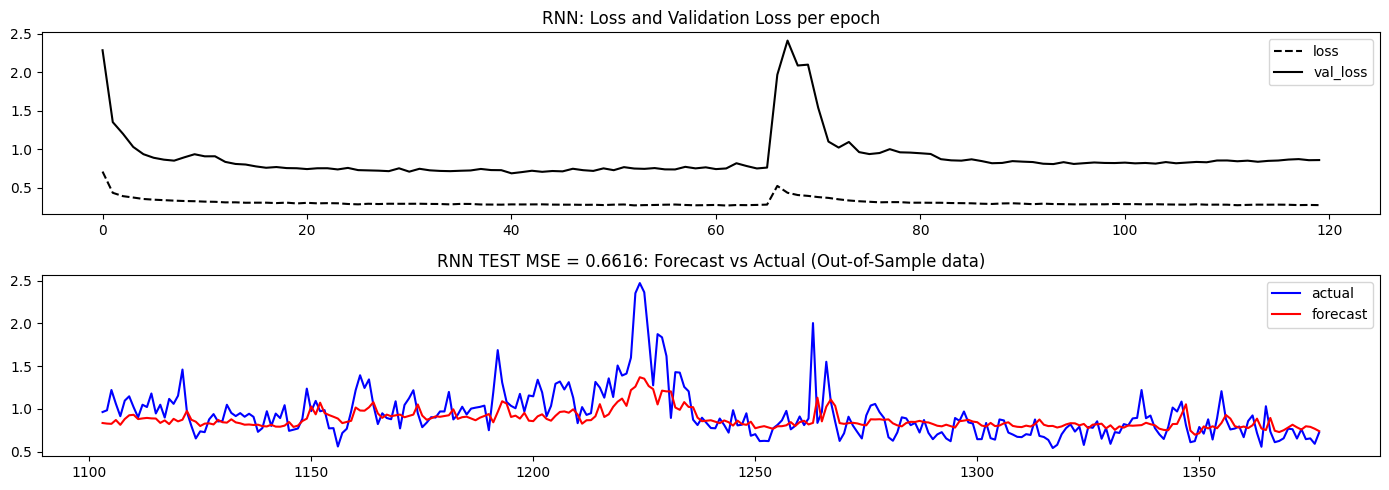

In [77]:

si_normal_rnn, history_normal_rnn = train_model_pt('RNN', **params_si)



## Inference simple RNN



## Inference sanity check first


In [78]:

model = si_normal_rnn


In [79]:


l_real, l_pred = inference_model_pt_2(model, model_type='RNN', **params_si)


0


In [80]:

l_real[:20]


[0.9630800273047798,
 0.98378829199744,
 1.2208307257867776,
 1.0601666819936835,
 0.9145106389945638,
 1.096306689299513,
 1.1471282138194072,
 1.019205839634076,
 0.9014426360042346,
 1.0485954160332076,
 1.021611559286487,
 1.1800714229221456,
 0.9466170094617548,
 1.0487394932487495,
 0.8986731943831988,
 1.1169999901401815,
 1.0589999774445755,
 1.1539999736232622,
 1.459963061047441,
 0.96425001560696]

In [81]:

l_pred[:20]


[array([0.85555273], dtype=float32),
 array([0.85315067], dtype=float32),
 array([0.8594144], dtype=float32),
 array([0.88172084], dtype=float32),
 array([0.7997822], dtype=float32),
 array([0.8833415], dtype=float32),
 array([0.95576215], dtype=float32),
 array([1.0667351], dtype=float32),
 array([0.9836229], dtype=float32),
 array([0.94300216], dtype=float32),
 array([0.90393245], dtype=float32),
 array([0.90033466], dtype=float32),
 array([0.9042833], dtype=float32),
 array([0.85783935], dtype=float32),
 array([0.8758375], dtype=float32),
 array([0.864708], dtype=float32),
 array([0.87961924], dtype=float32),
 array([0.86061984], dtype=float32),
 array([0.8833563], dtype=float32),
 array([1.0035607], dtype=float32)]

In [82]:

## plt.rcParams["figure.figsize"] = [14, 5] 


275


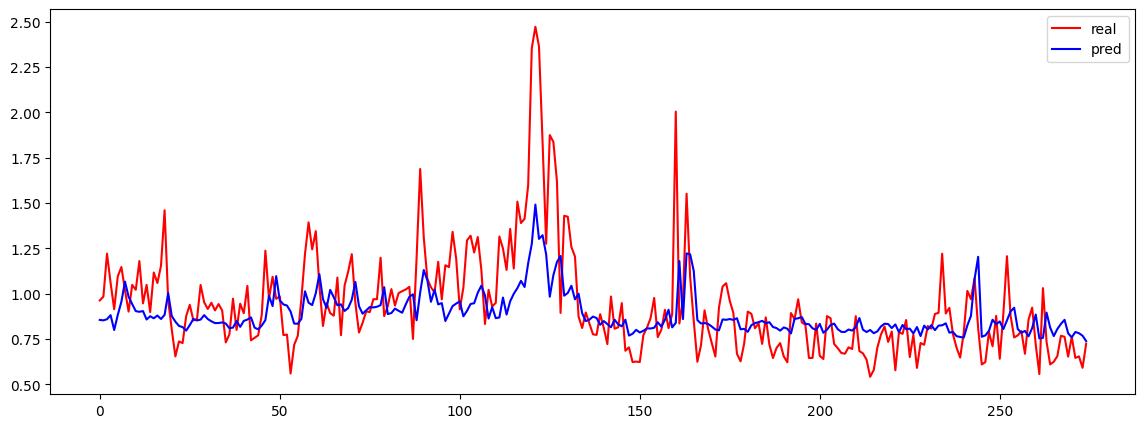

In [83]:


  
# create data 
x = [ i for i in range(len(l_real)) ] 
print(len(x))
  
# plot lines 

plt.plot(x, l_real, label = "real", color='red') 
plt.plot(x, l_pred, label = "pred", color='blue') 
plt.legend() 
plt.show()



## Now run actual INFERENCE to predict x vector and silicon together


In [84]:

model = si_normal_rnn


In [85]:

l_real, l_pred = inference_model_pt(model, model_type='RNN', **params_si)


0


In [86]:

l_real[:20]


[0.9630800273047798,
 0.98378829199744,
 1.2208307257867776,
 1.0601666819936835,
 0.9145106389945638,
 1.096306689299513,
 1.1471282138194072,
 1.019205839634076,
 0.9014426360042346,
 1.0485954160332076,
 1.021611559286487,
 1.1800714229221456,
 0.9466170094617548,
 1.0487394932487495,
 0.8986731943831988,
 1.1169999901401815,
 1.0589999774445755,
 1.1539999736232622,
 1.459963061047441,
 0.96425001560696]

In [87]:

l_pred[:20]


[array([0.85555273], dtype=float32),
 array([0.8552341], dtype=float32),
 array([0.8584247], dtype=float32),
 array([0.87377924], dtype=float32),
 array([0.8990226], dtype=float32),
 array([0.91345805], dtype=float32),
 array([0.9247064], dtype=float32),
 array([0.92848957], dtype=float32),
 array([0.92838895], dtype=float32),
 array([0.9266661], dtype=float32),
 array([0.92144036], dtype=float32),
 array([0.916254], dtype=float32),
 array([0.9143221], dtype=float32),
 array([0.91071624], dtype=float32),
 array([0.90486497], dtype=float32),
 array([0.89758307], dtype=float32),
 array([0.8895027], dtype=float32),
 array([0.88009953], dtype=float32),
 array([0.8679244], dtype=float32),
 array([0.8534945], dtype=float32)]

275


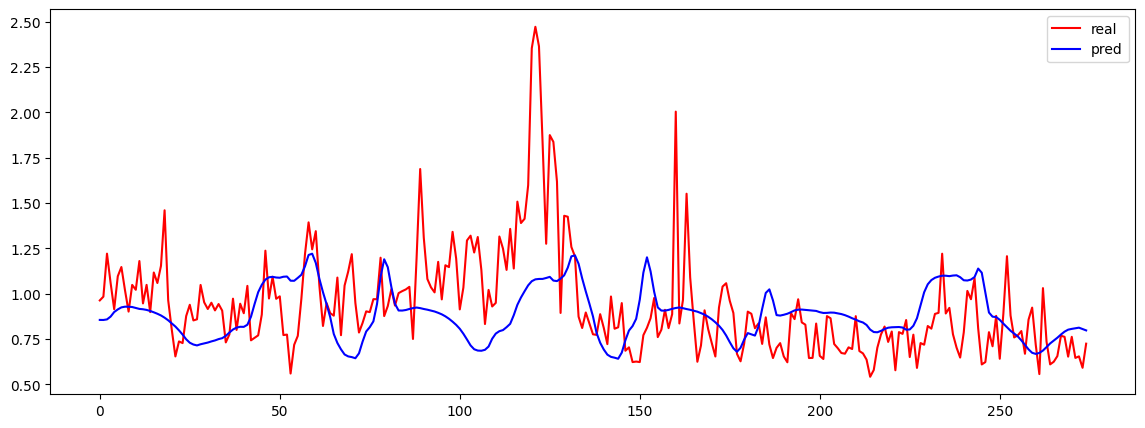

In [88]:

# create data 
x = [ i for i in range(len(l_real)) ] 
print(len(x))
  
# plot lines 

plt.plot(x, l_real, label = "real", color='red') 
plt.plot(x, l_pred, label = "pred", color='blue') 
plt.legend() 
plt.show()



## Break up test set into test bins 

* example
* input is 30 (about 7.5 hours)
* predicts rest of week


In [89]:

model = si_normal_rnn


In [90]:

x_test, y_test   = params_si['test_data']

## l_real, l_pred = bins_inference_model_pt(model, x_test, y_test)




In [91]:

x_test.shape


torch.Size([275, 120])

In [92]:

bin_size = int( x_test.shape[0] / window )
bin_size 


55

In [93]:

318/ 30


10.6

In [94]:

bin_size = 20


torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0444
20


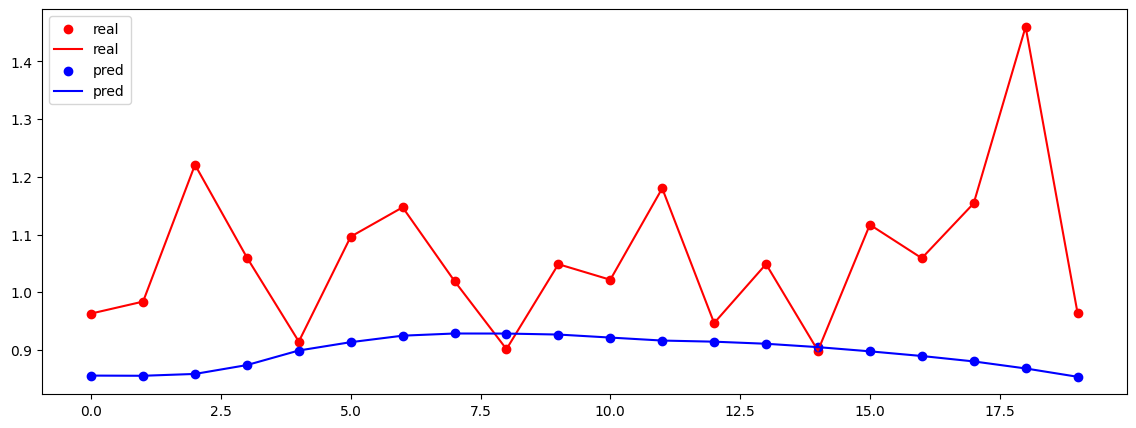

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0135
20


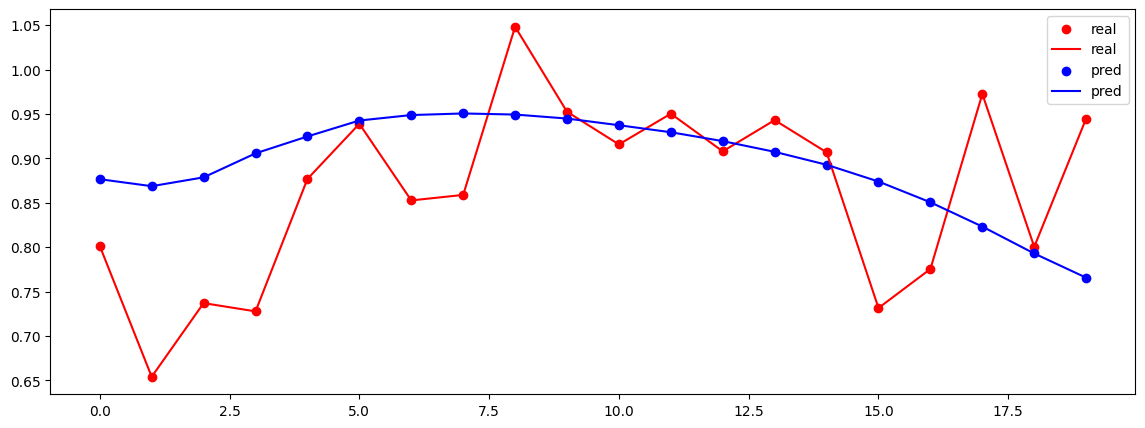

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0478
20


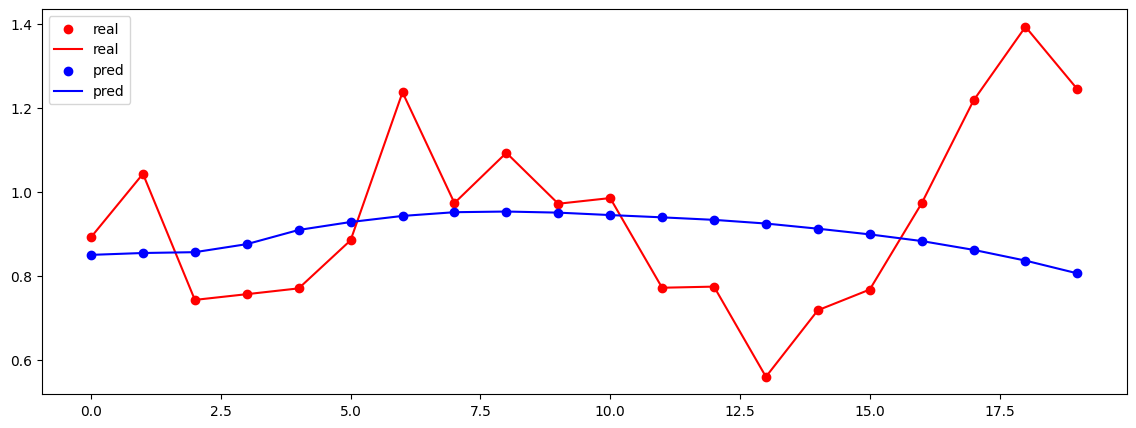

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0276
20


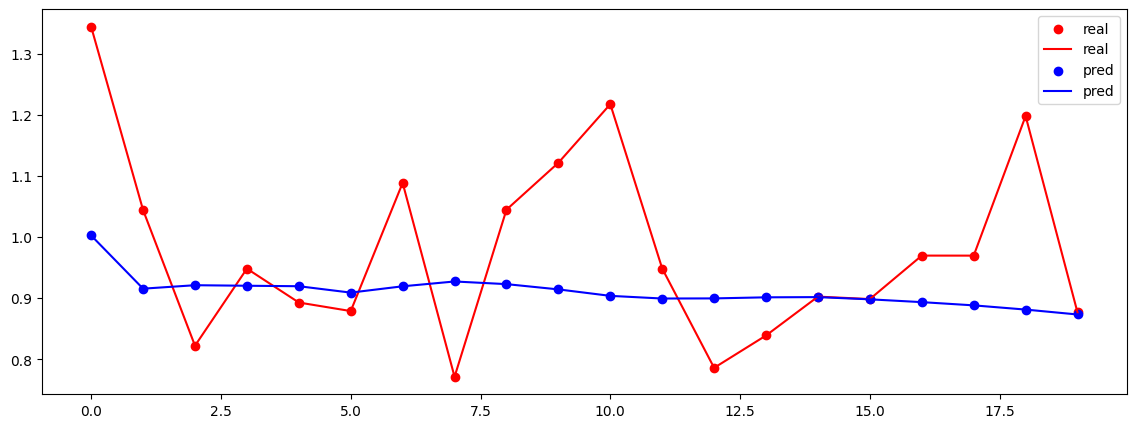

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0763
20


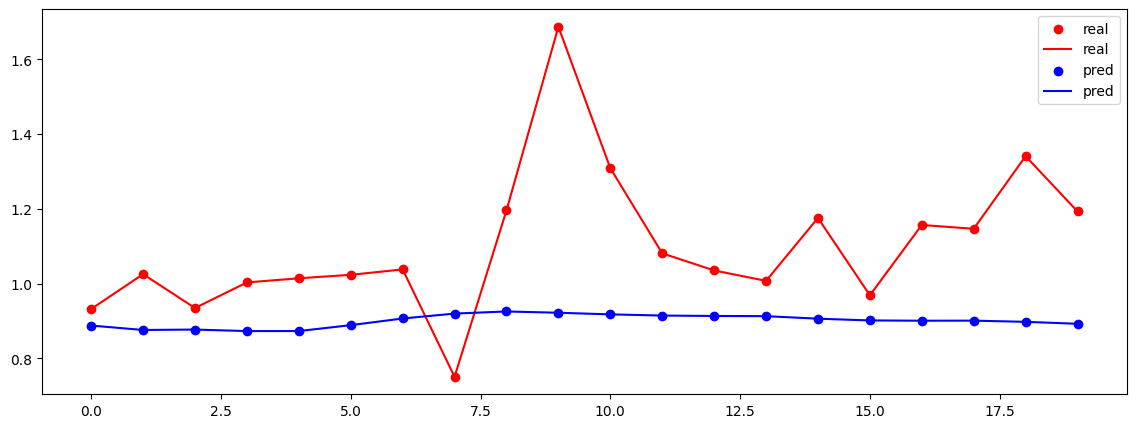

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.1275
20


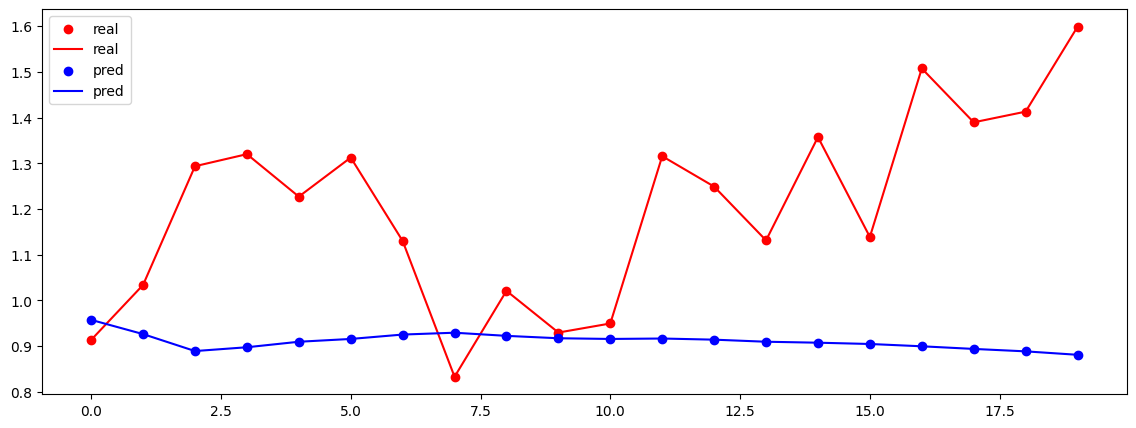

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.5511
20


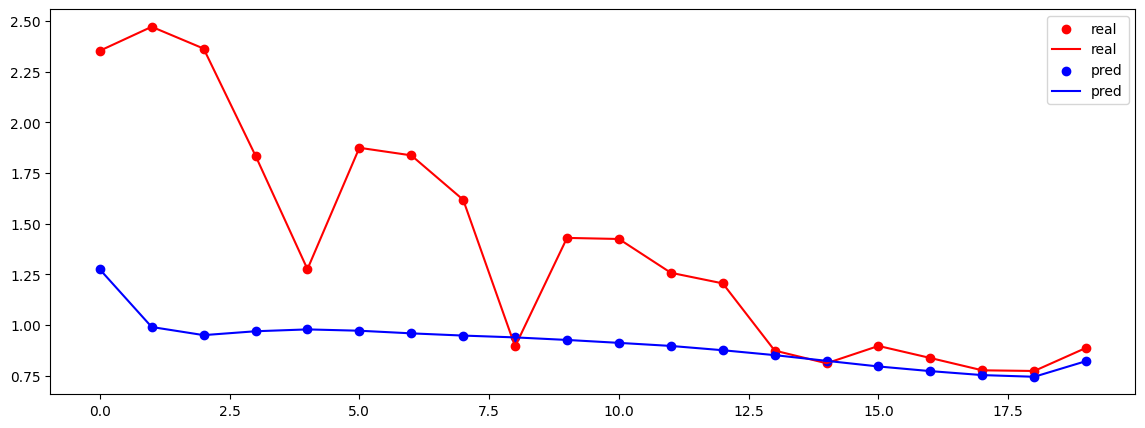

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0743
20


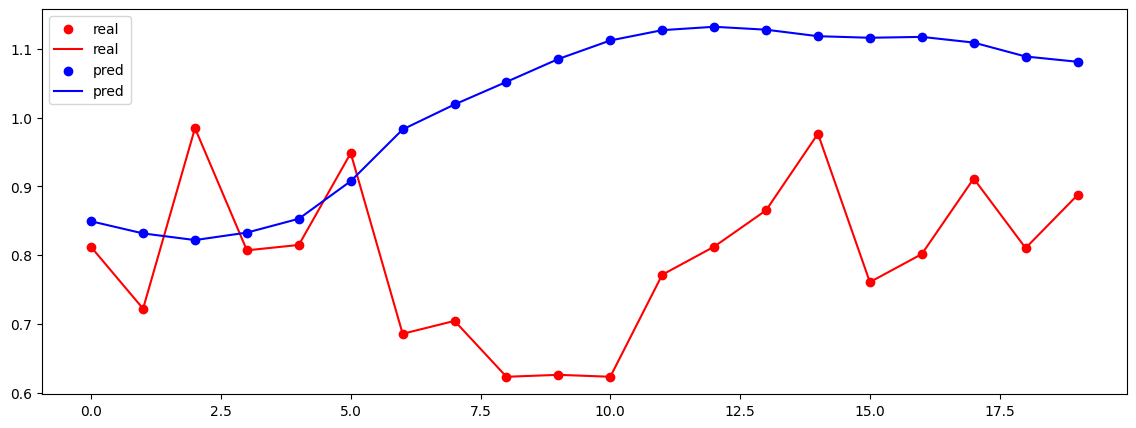

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.1190
20


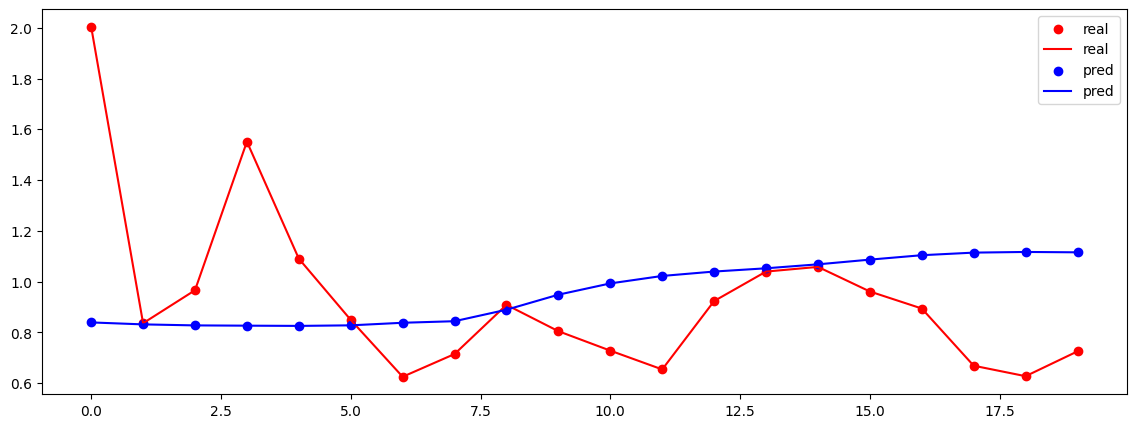

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0940
20


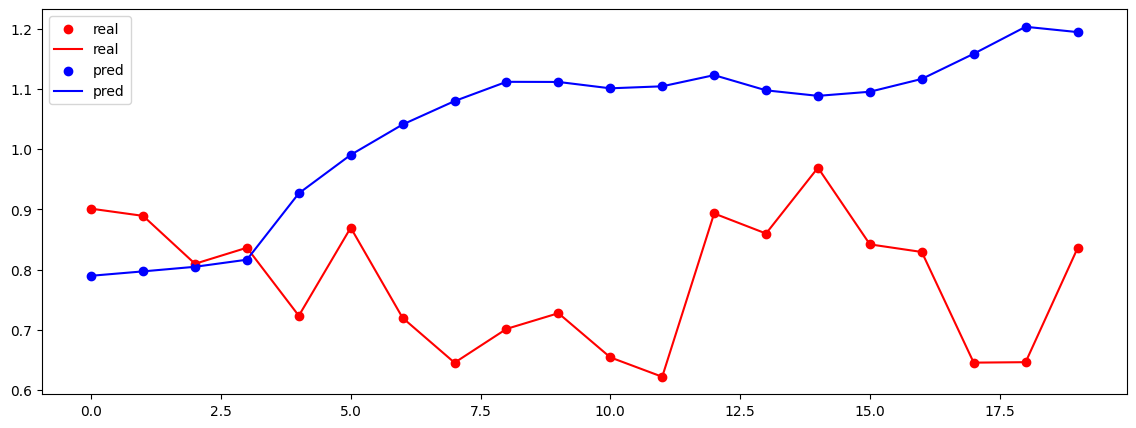

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.1022
20


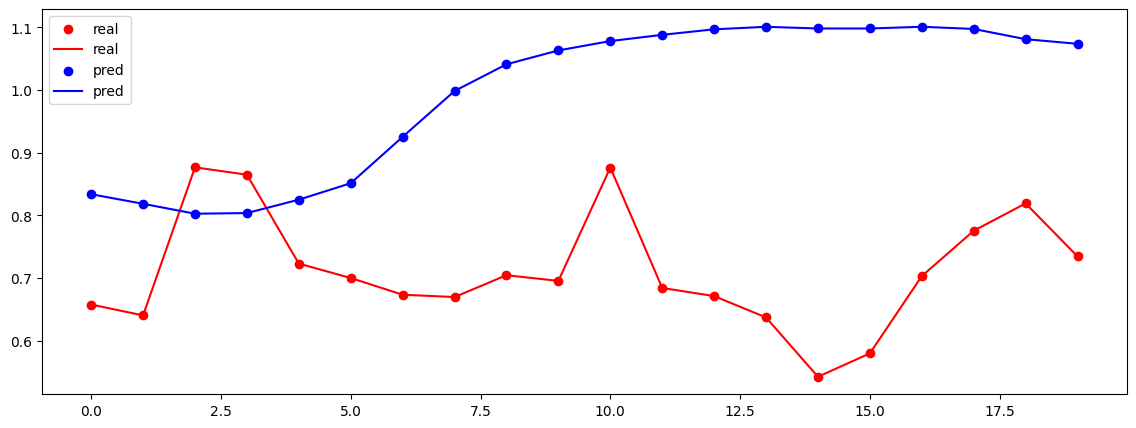

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0840
20


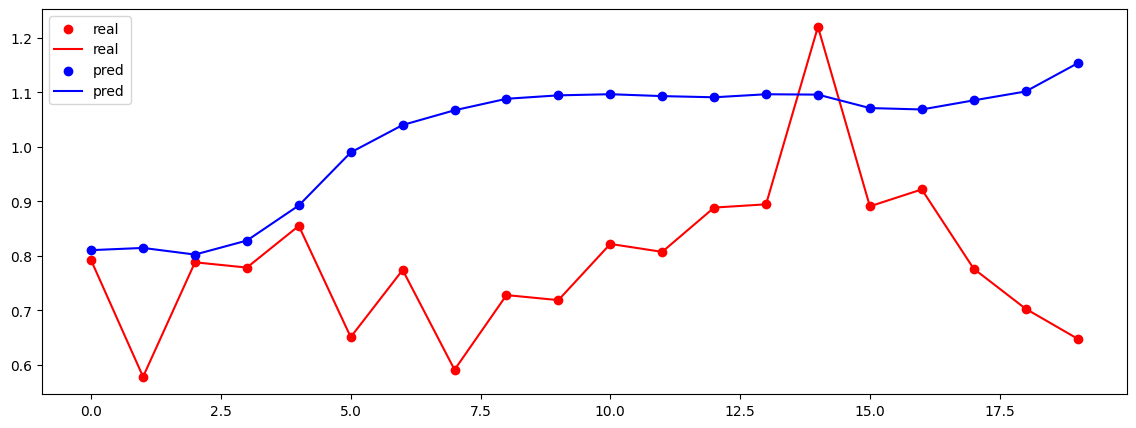

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0554
20


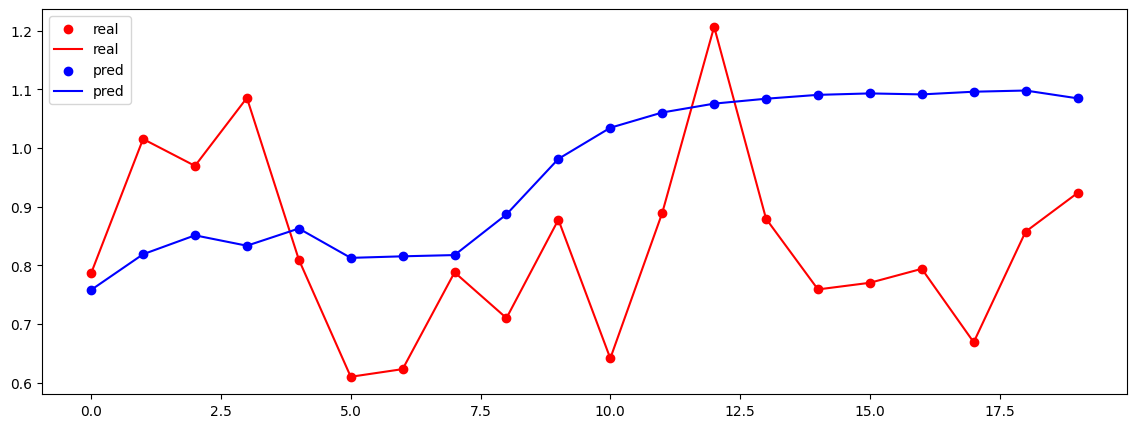

In [95]:

for i in range(0, y_test.shape[0]- bin_size, bin_size):
    batch_x_test = x_test[i:i+bin_size, :]
    print( batch_x_test.shape )

    batch_y_test = y_test[i:i+bin_size, :]
    print( batch_y_test.shape )
    print("---------------")
    bins_inference_model_pt(model, batch_x_test, batch_y_test)




## LSTM


In [96]:

class LSTM(nn.Module):
    def __init__(self, seq_length, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers   = n_layers
        self.hidden_dim = n_features
        self.output_size= output_size
        self.seq_length = seq_length
        self.input_size = input_size

        self.lstm    = nn.LSTM(input_size, n_features, n_layers, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc      = nn.Linear(n_features, output_size)

        self.Attention  = SelfAttentionLayer( seq_length * input_size )    ## or n_features if after LSTM

        self.fc1     = nn.Linear(n_features, 40)
        self.relu    = nn.ReLU()
        self.fc2     = nn.Linear(40, output_size)
        
    def forward(self, x, hn):

        x2     = self.Attention(x)  
        x2     = x2[0]
        x = x2 + x

        x = x.view(-1, self.seq_length, self.input_size)
        x = x.permute(1, 0, 2)


       
        ## hn is a tuple here of (h0, c0)
        lstm_o, (hn, cn) = self.lstm(x, hn)
    
        lstm_o = self.dropout(lstm_o)

        hn = hn[-1, :, :]

        ## x     = self.Attention(hn)  
        ## x     = x[0]
        ## hn = hn + x

        
        ## output = self.fc( hn )
        
        output    = self.fc1( hn )
        output    = self.relu( output )
        output    = self.dropout(  output  )
        output    = self.fc2( output )
    
        ##                     batch_size, n_classes) 
        output  = output.view( -1,  self.output_size ) 
        
        return output, hn


    def init_hidden(self, batch_size_x_data):
        weight = next(self.parameters()).data
        hidden = ( weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, 1, self.hidden_dim).zero_()   )
        N_batches_rc = batch_size_x_data    ## or is this the size of the x set ??
        hidden2 = ( torch.zeros( self.n_layers,   N_batches_rc,    self.hidden_dim ),
                    torch.zeros( self.n_layers,   N_batches_rc,    self.hidden_dim )    )
        return hidden2


0/3000 - Loss:  0.7184374332427979, val_loss: 2.401195764541626
25/3000 - Loss:  0.4157317876815796, val_loss: 1.360254168510437
50/3000 - Loss:  0.35017308592796326, val_loss: 1.0114972591400146
75/3000 - Loss:  0.3286835253238678, val_loss: 0.8802821636199951
100/3000 - Loss:  0.3177665174007416, val_loss: 0.8746839761734009
125/3000 - Loss:  0.314623087644577, val_loss: 0.8177077174186707
150/3000 - Loss:  0.30801695585250854, val_loss: 0.8233315348625183
175/3000 - Loss:  0.30871498584747314, val_loss: 0.8022980093955994
200/3000 - Loss:  0.30290597677230835, val_loss: 0.7763063311576843
225/3000 - Loss:  0.2994160056114197, val_loss: 0.7831770181655884
250/3000 - Loss:  0.29512879252433777, val_loss: 0.765961229801178
275/3000 - Loss:  0.29459890723228455, val_loss: 0.7762669324874878
300/3000 - Loss:  0.29518985748291016, val_loss: 0.773155689239502
325/3000 - Loss:  0.28920161724090576, val_loss: 0.7961180806159973
350/3000 - Loss:  0.28822094202041626, val_loss: 0.7876471877098

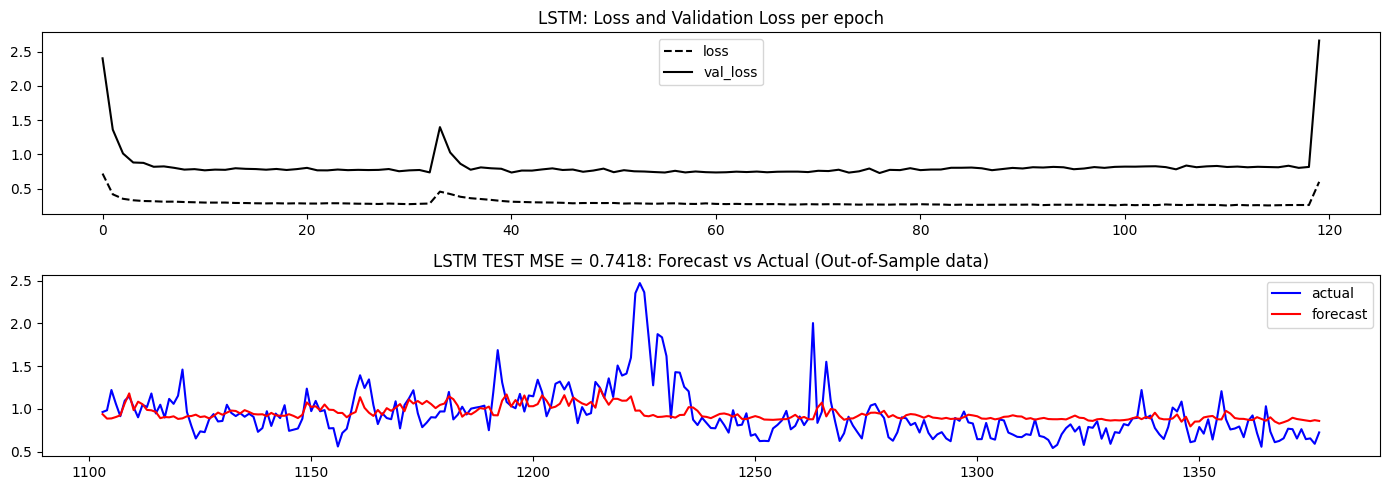

In [97]:

si_lstm, history_a_lstm = train_model_pt('LSTM', **params_si)



## LSTM Inference



## Inference sanity check first


In [98]:

model = si_lstm


In [99]:

l_real, l_pred = inference_model_pt_2(model, model_type='LSTM', **params_si)


0


In [100]:

l_real[:20]


[0.9630800273047798,
 0.98378829199744,
 1.2208307257867776,
 1.0601666819936835,
 0.9145106389945638,
 1.096306689299513,
 1.1471282138194072,
 1.019205839634076,
 0.9014426360042346,
 1.0485954160332076,
 1.021611559286487,
 1.1800714229221456,
 0.9466170094617548,
 1.0487394932487495,
 0.8986731943831988,
 1.1169999901401815,
 1.0589999774445755,
 1.1539999736232622,
 1.459963061047441,
 0.96425001560696]

In [101]:

l_pred[:20]


[array([0.89481974], dtype=float32),
 array([0.89599824], dtype=float32),
 array([0.87111247], dtype=float32),
 array([0.94675684], dtype=float32),
 array([0.9449322], dtype=float32),
 array([0.9508416], dtype=float32),
 array([0.98342216], dtype=float32),
 array([0.9402621], dtype=float32),
 array([0.9273813], dtype=float32),
 array([0.9343533], dtype=float32),
 array([0.94634867], dtype=float32),
 array([1.0108114], dtype=float32),
 array([1.029522], dtype=float32),
 array([1.0344265], dtype=float32),
 array([1.0225532], dtype=float32),
 array([0.94126695], dtype=float32),
 array([0.9295868], dtype=float32),
 array([0.9015483], dtype=float32),
 array([0.9714304], dtype=float32),
 array([0.9912912], dtype=float32)]

275


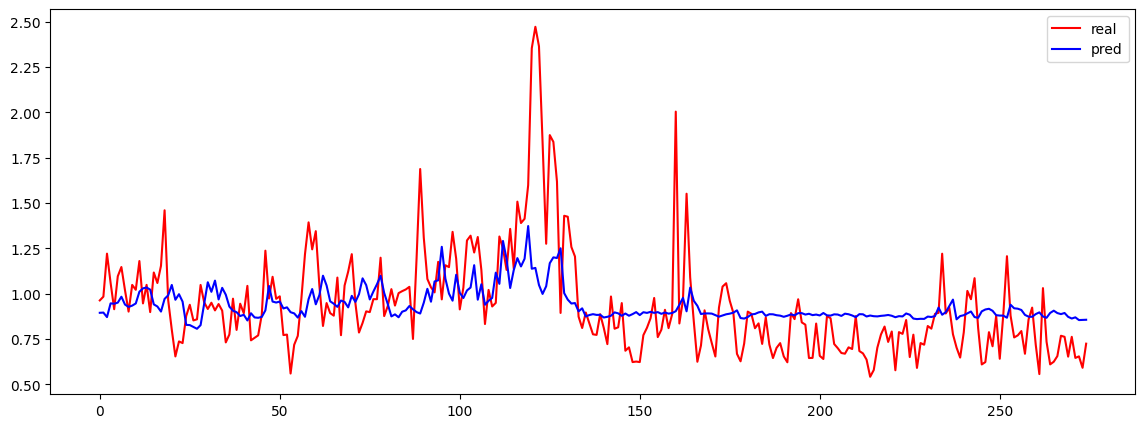

In [102]:

# create data 
x = [ i for i in range(len(l_real)) ] 
print(len(x))
  
# plot lines 

plt.plot(x, l_real, label = "real", color='red') 
plt.plot(x, l_pred, label = "pred", color='blue') 
plt.legend() 
plt.show()



## Now run actual INFERENCE to predict x vector and silicon together


In [103]:

model = si_lstm


In [104]:

l_real, l_pred = inference_model_pt(model, model_type='LSTM', **params_si)


0


In [105]:

l_real[:50]


[0.9630800273047798,
 0.98378829199744,
 1.2208307257867776,
 1.0601666819936835,
 0.9145106389945638,
 1.096306689299513,
 1.1471282138194072,
 1.019205839634076,
 0.9014426360042346,
 1.0485954160332076,
 1.021611559286487,
 1.1800714229221456,
 0.9466170094617548,
 1.0487394932487495,
 0.8986731943831988,
 1.1169999901401815,
 1.0589999774445755,
 1.1539999736232622,
 1.459963061047441,
 0.96425001560696,
 0.801413847341183,
 0.6541764783769621,
 0.7371185332744226,
 0.7278170817408631,
 0.8769224761878993,
 0.9390000110763491,
 0.8527525969632564,
 0.8589317398186438,
 1.0482456521397214,
 0.9525810800882323,
 0.9158200185354637,
 0.9503839161485412,
 0.9080000129942244,
 0.9431447091349661,
 0.9069230771099127,
 0.7316078381290521,
 0.7755384850114699,
 0.9726199962483455,
 0.8004740684857498,
 0.9449705846216954,
 0.8923706839885343,
 1.0432205717240468,
 0.743052050720141,
 0.7566666813201011,
 0.7704999976370823,
 0.8849999903477125,
 1.2372499806514883,
 0.9736666908404534,
 1

In [106]:

l_pred[:500]


[array([0.89481974], dtype=float32),
 array([0.9041793], dtype=float32),
 array([0.87337893], dtype=float32),
 array([0.901719], dtype=float32),
 array([0.9375541], dtype=float32),
 array([0.96889055], dtype=float32),
 array([0.98975885], dtype=float32),
 array([0.98199666], dtype=float32),
 array([0.9506006], dtype=float32),
 array([0.9666867], dtype=float32),
 array([1.0029182], dtype=float32),
 array([1.0394584], dtype=float32),
 array([1.0616784], dtype=float32),
 array([1.0718976], dtype=float32),
 array([1.0716244], dtype=float32),
 array([1.0667255], dtype=float32),
 array([1.0605527], dtype=float32),
 array([1.0542287], dtype=float32),
 array([1.0475862], dtype=float32),
 array([1.041182], dtype=float32),
 array([1.0364311], dtype=float32),
 array([1.0332693], dtype=float32),
 array([1.0312823], dtype=float32),
 array([1.0303276], dtype=float32),
 array([1.0303776], dtype=float32),
 array([1.0312145], dtype=float32),
 array([1.0325222], dtype=float32),
 array([1.0339918], dtype

275


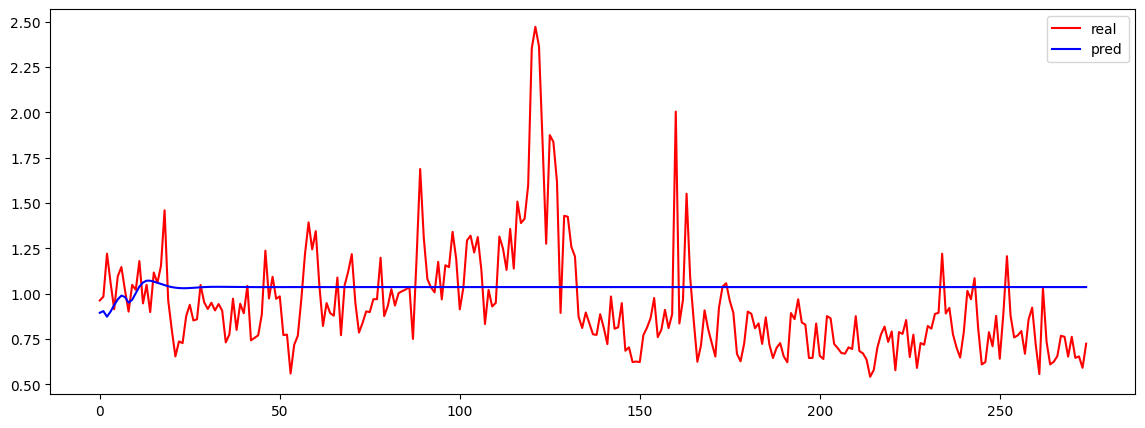

In [107]:

# create data 
x = [ i for i in range(len(l_real)) ] 
print(len(x))
  
# plot lines 

plt.plot(x, l_real, label = "real", color='red') 
plt.plot(x, l_pred, label = "pred", color='blue') 
plt.legend() 
plt.show()



## Break up test set into test bins 

* example
* input is 30 (about 7.5 hours)
* predicts rest of week


In [108]:

model = si_lstm


In [109]:


x_test, y_test   = params_si['test_data']

## l_real, l_pred = bins_inference_model_pt(model, x_test, y_test)



In [110]:

x_test.shape


torch.Size([275, 120])

In [111]:

bin_size = int( x_test.shape[0] / window )
bin_size 


55

In [112]:

bin_size = 20


torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0253
20


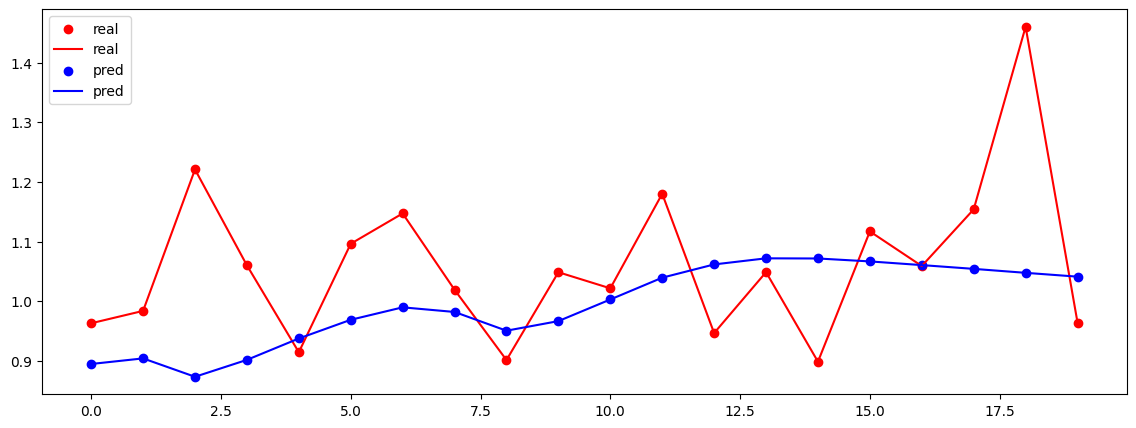

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0465
20


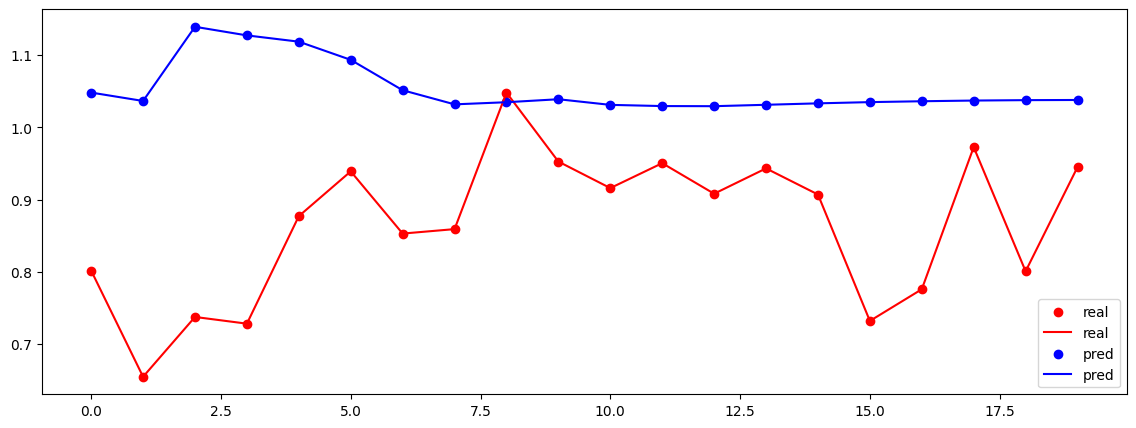

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0517
20


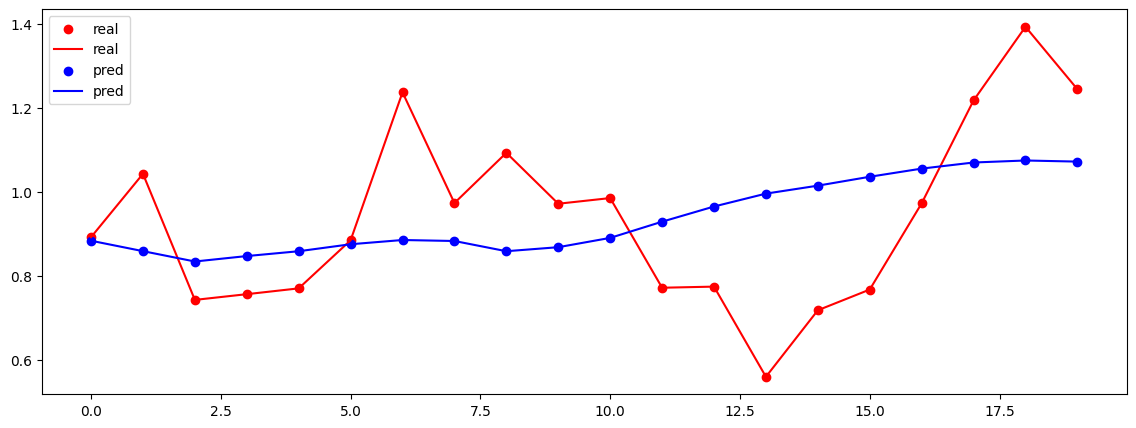

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0259
20


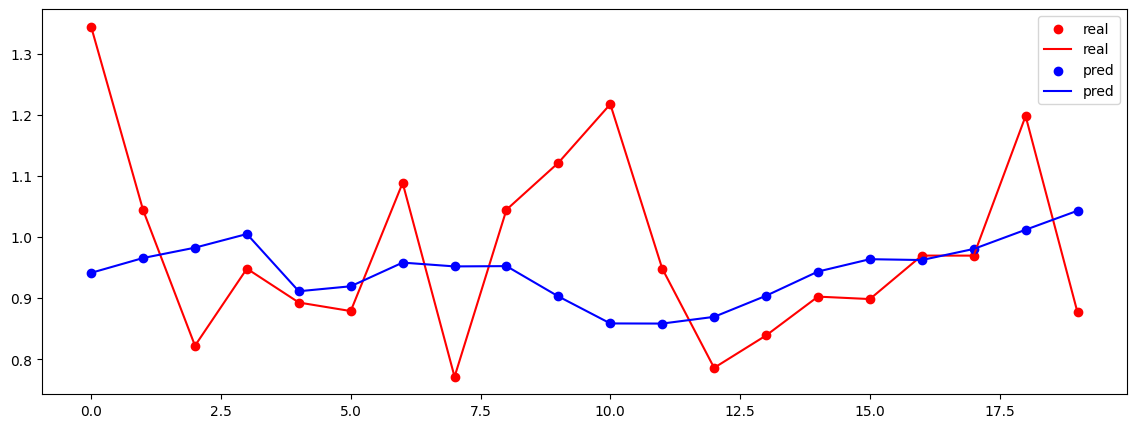

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0416
20


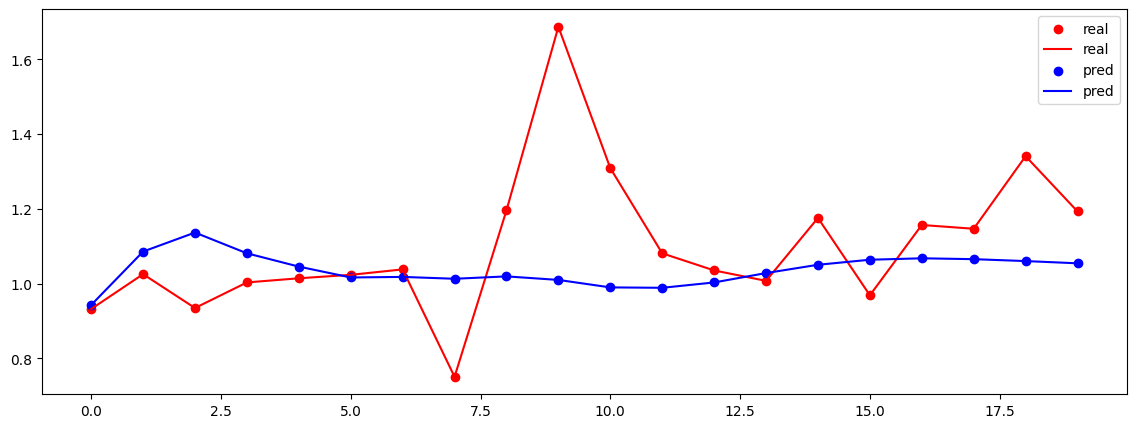

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0824
20


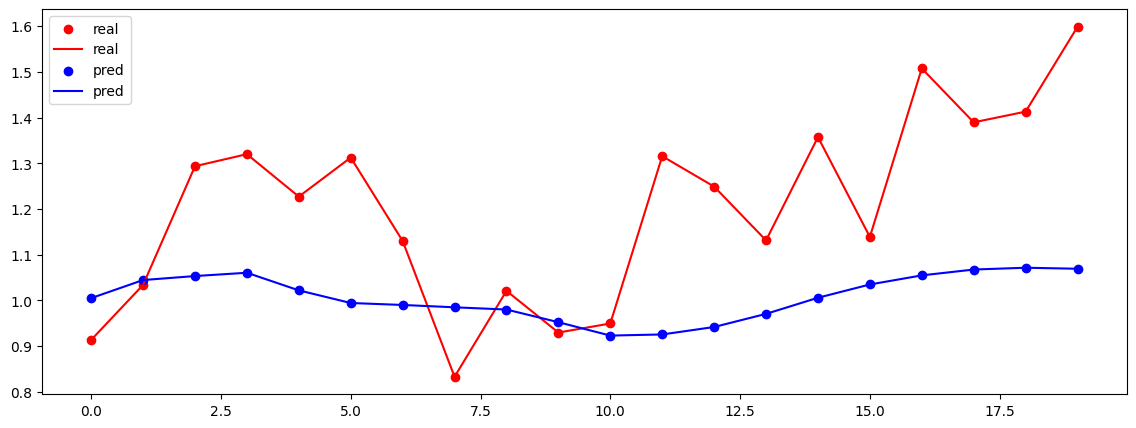

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.4184
20


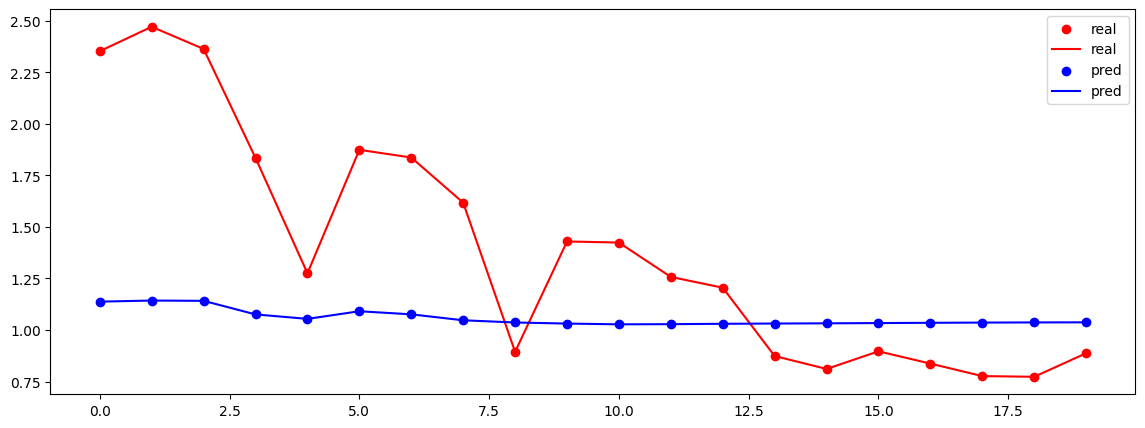

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0150
20


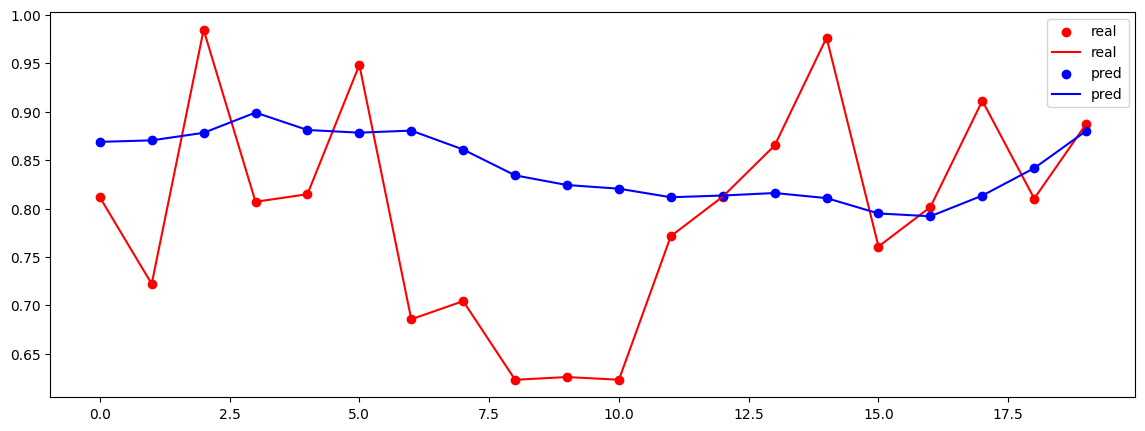

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.1137
20


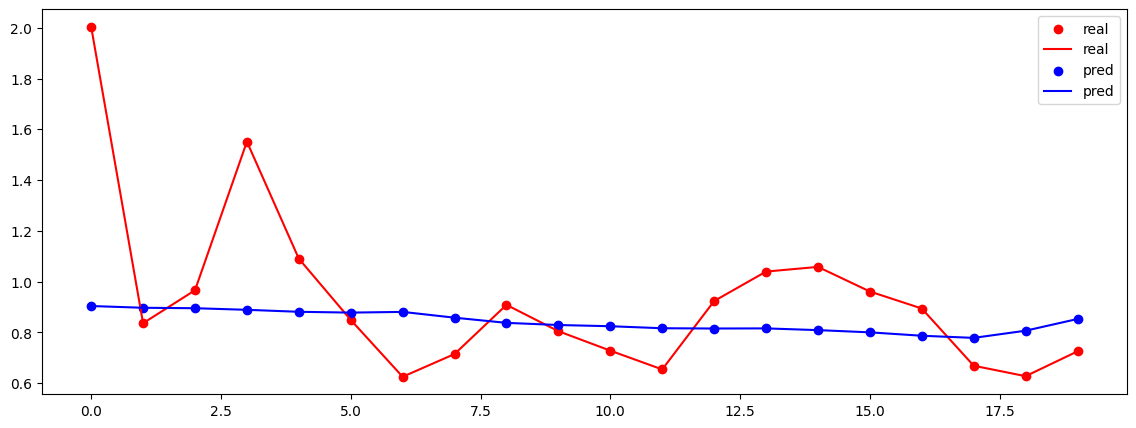

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0156
20


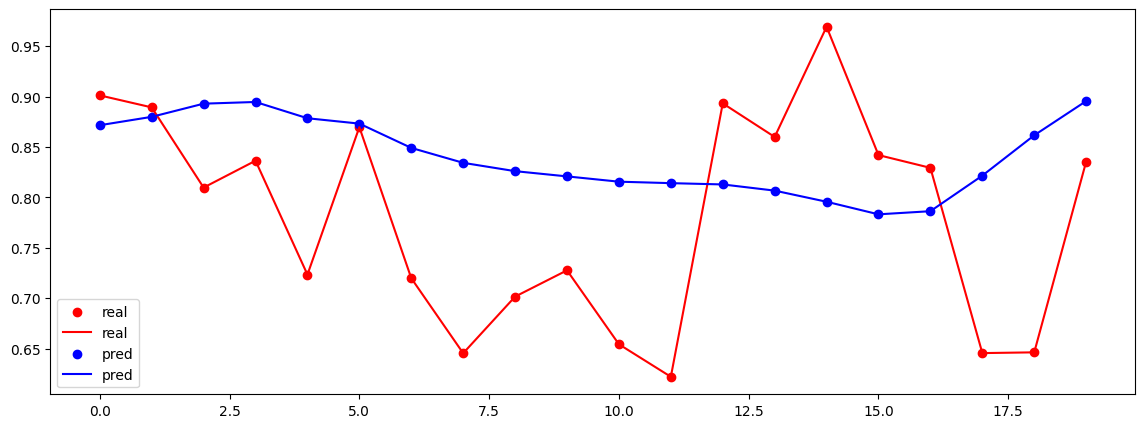

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0238
20


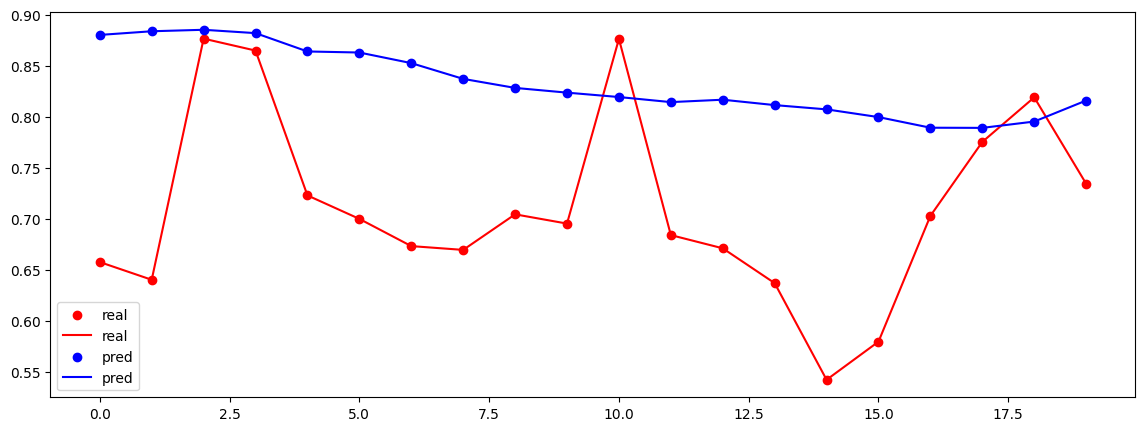

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0220
20


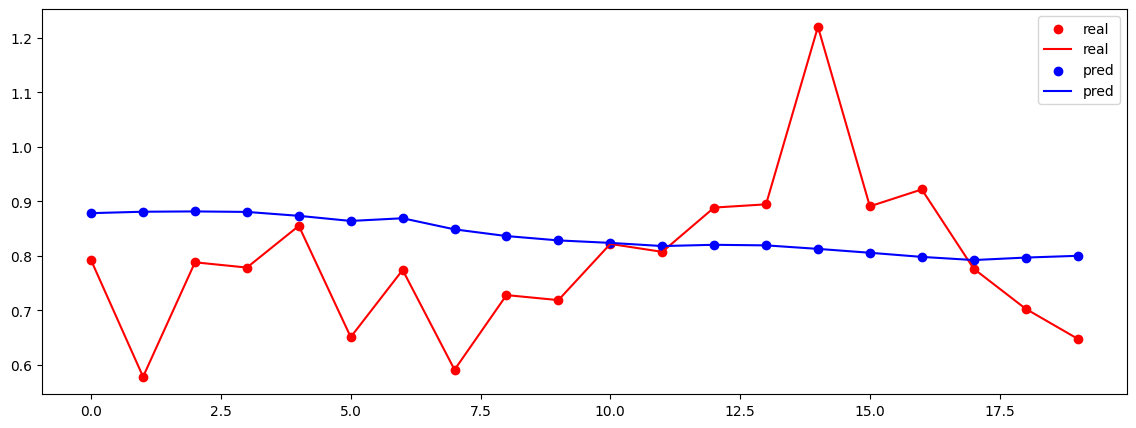

torch.Size([20, 120])
torch.Size([20, 24])
---------------
0
Test MSE Loss: 0.0240
20


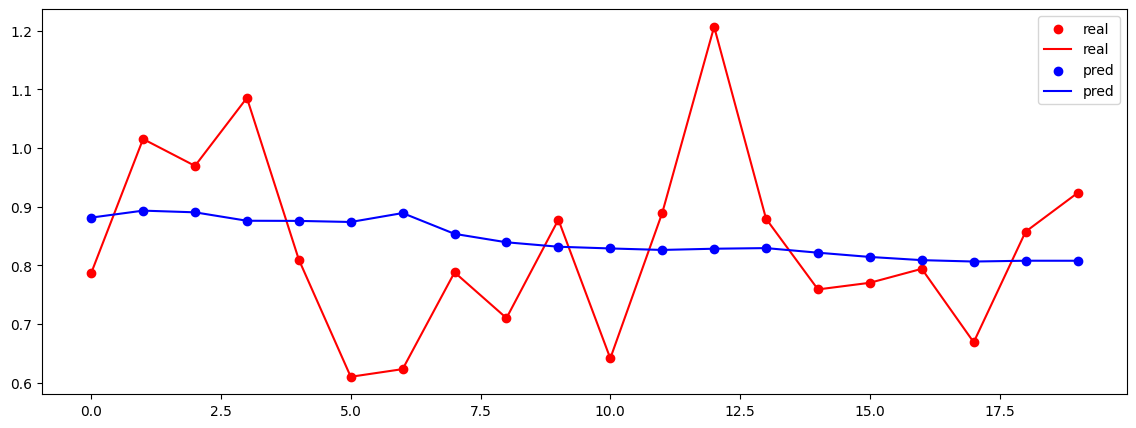

In [113]:



for i in range(0, y_test.shape[0]- bin_size, bin_size):
    batch_x_test = x_test[i:i+bin_size, :]
    print( batch_x_test.shape )

    batch_y_test = y_test[i:i+bin_size, :]
    print( batch_y_test.shape )
    print("---------------")
    bins_inference_model_pt(model, batch_x_test, batch_y_test)



## View all predicted Xs


In [114]:


            
            
def View_all_predicted_Xs(x_index, model, model_type='RNN', **kwargs):
 
    x_test, y_test   = kwargs['test_data']
 
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0    = model.init_hidden( x_test.shape[0] )
        y_hat = model(x_test, h0)
        
    y_hat, _ = y_hat
 
    ## Plotting
    fig, ax = plt.subplots(2, 1) 
    
    ax[0].set_title(f"{model_type} TEST MSE = {0:.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    print("ricardo check this")
    print(y_test.shape)
    print(y_hat.shape )
    actual = scale.inverse_y(y_test.detach().numpy() ) ## .ravel() )
    pred   = scale.inverse_y( y_hat.detach().numpy() ) ## .ravel() )
    idx = kwargs['idx']
    ##pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65, color='blue')
    ##pd.Series(pred,   index=idx).plot(style='k',   label='forecast' , color='red')
    print(actual.shape)
    print(pred.shape)
    actual = actual[:, x_index]
    pred   =   pred[:, x_index]
    
    pd.Series(pred,   index=idx).plot( label='forecast' , color='red' )
    pd.Series(actual, index=idx).plot( label='actual',    color='blue')
    
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return 0, 0
    
           

            



ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


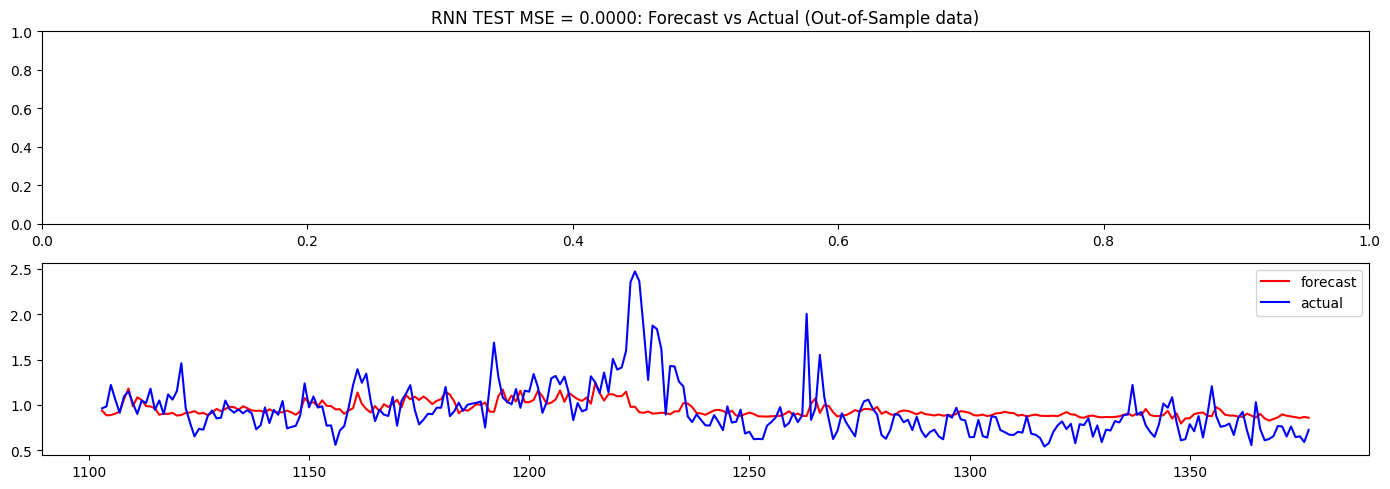

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


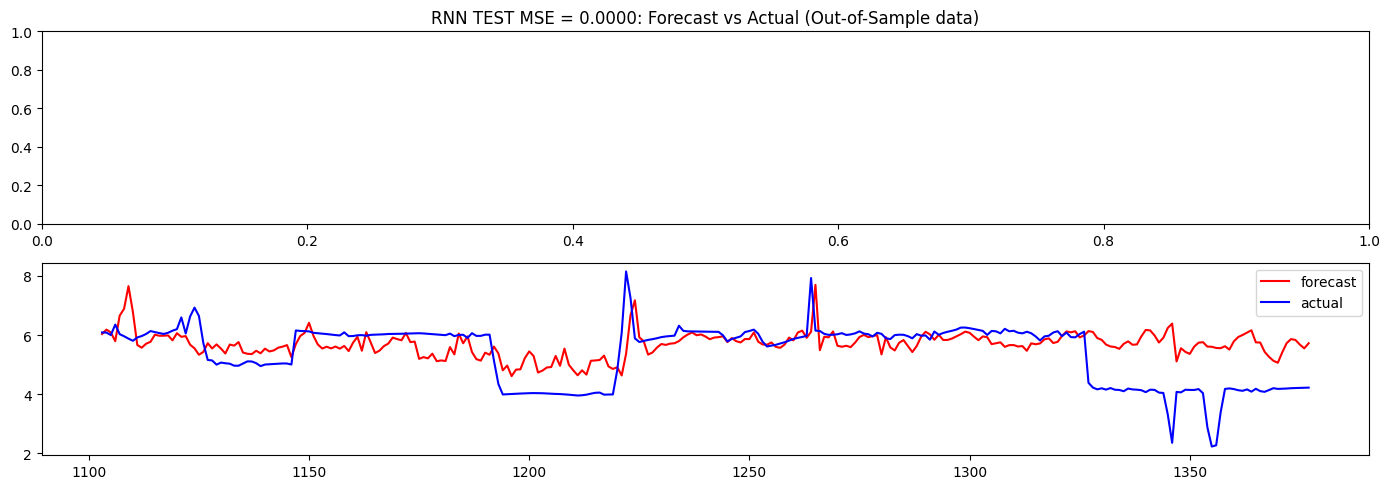

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


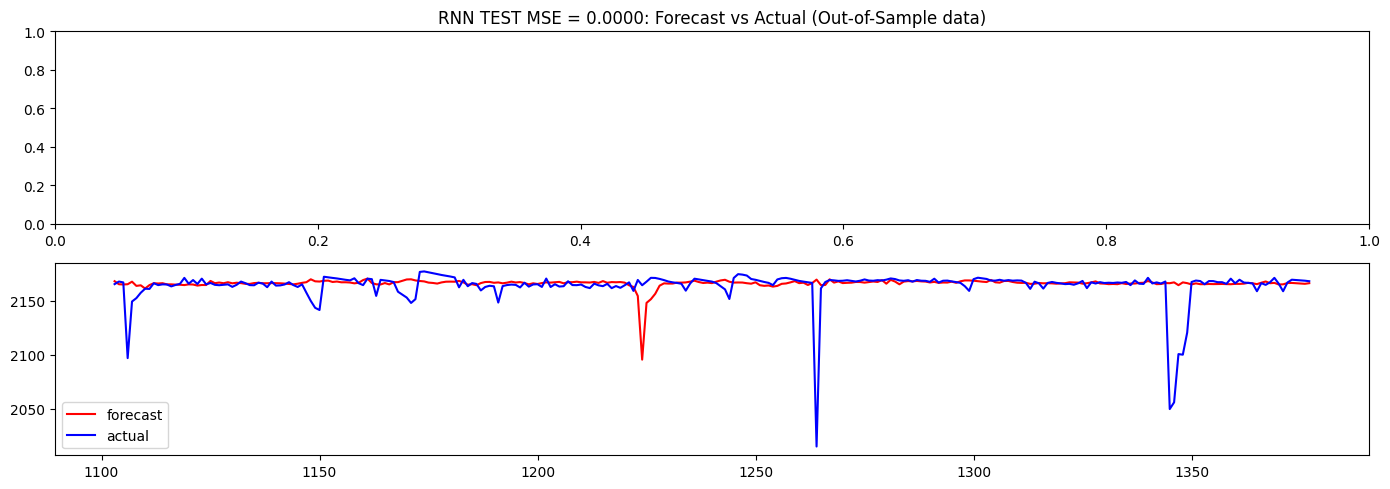

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


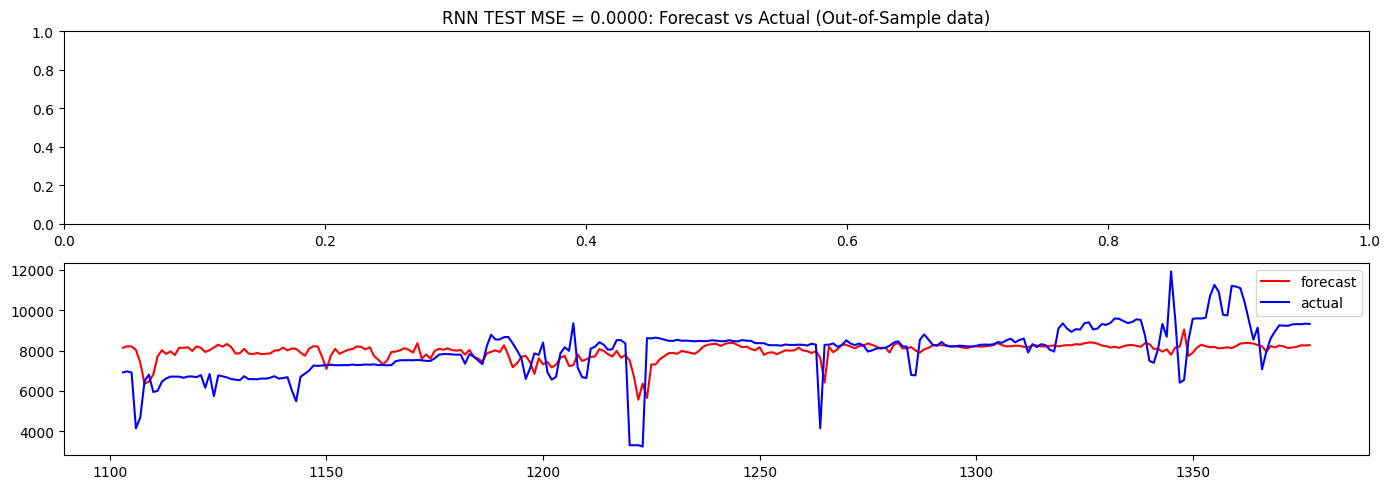

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


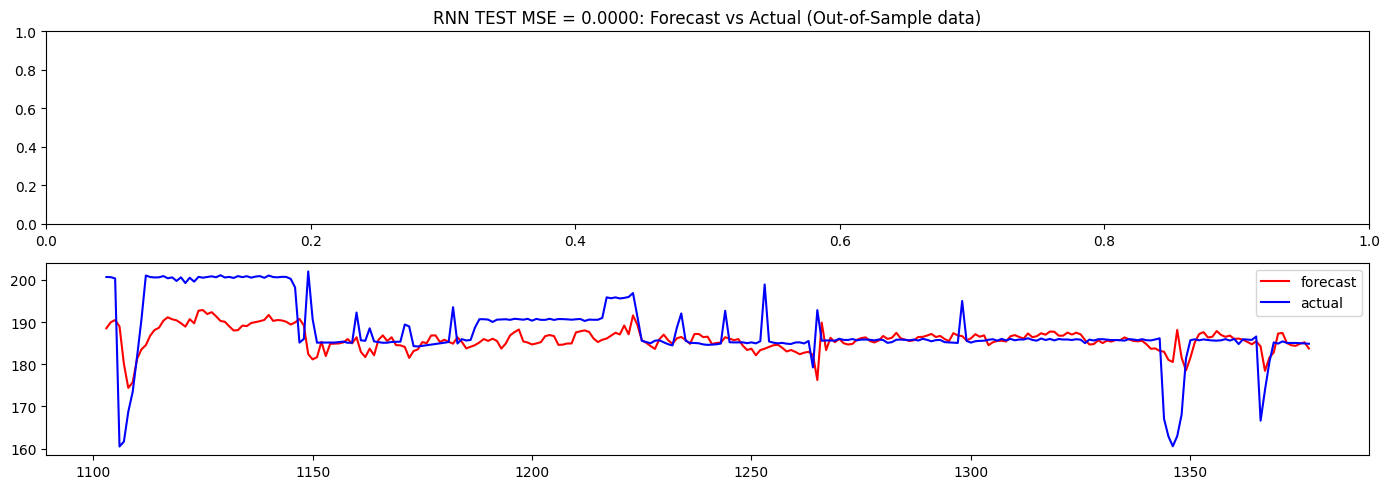

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


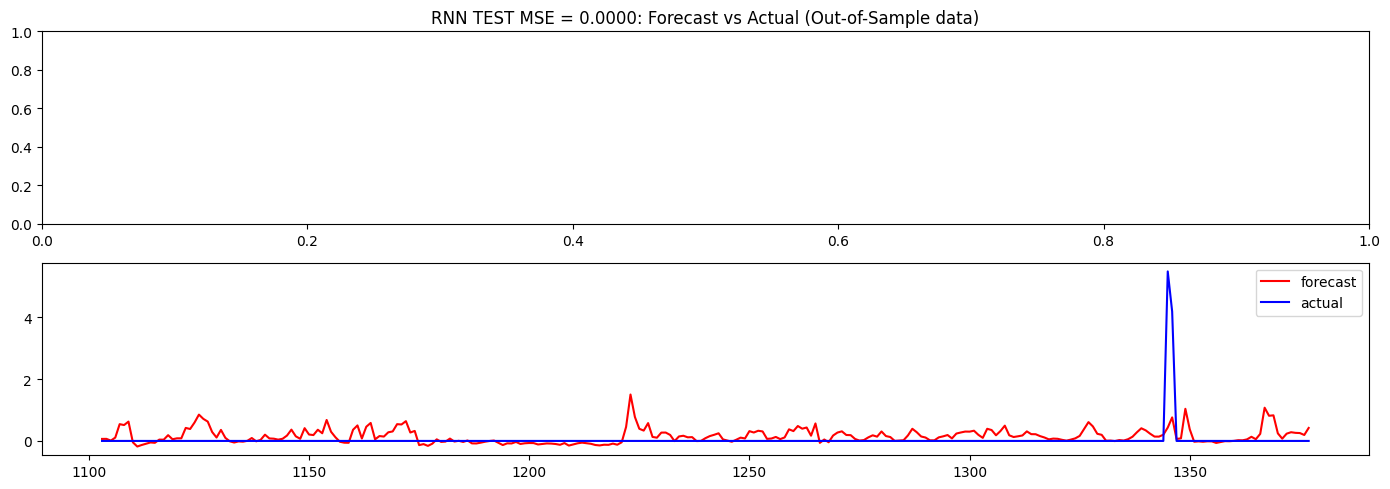

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


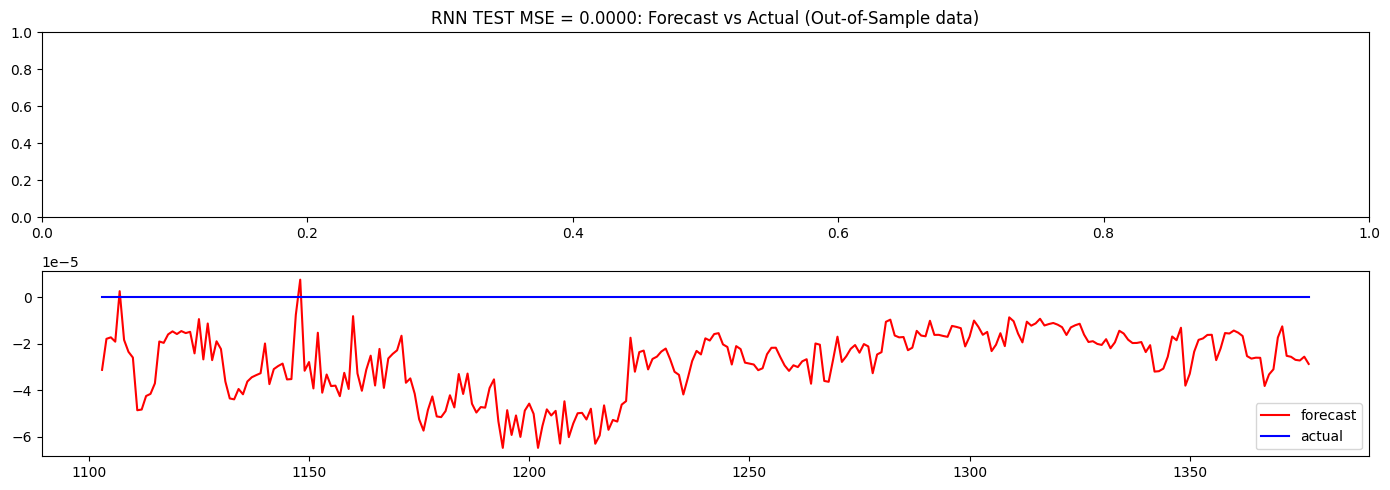

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


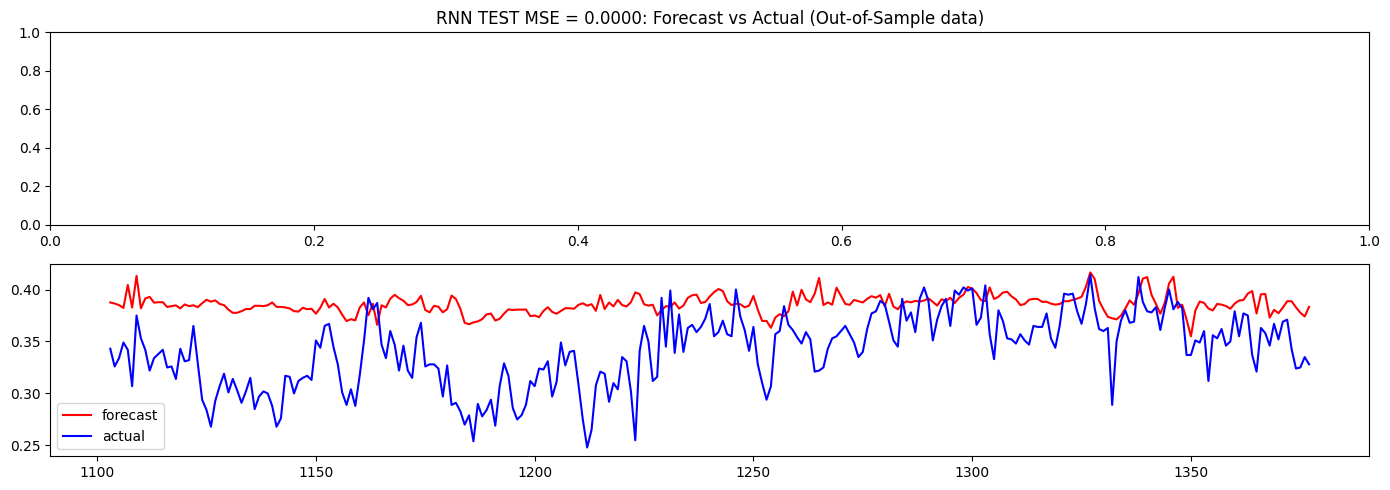

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


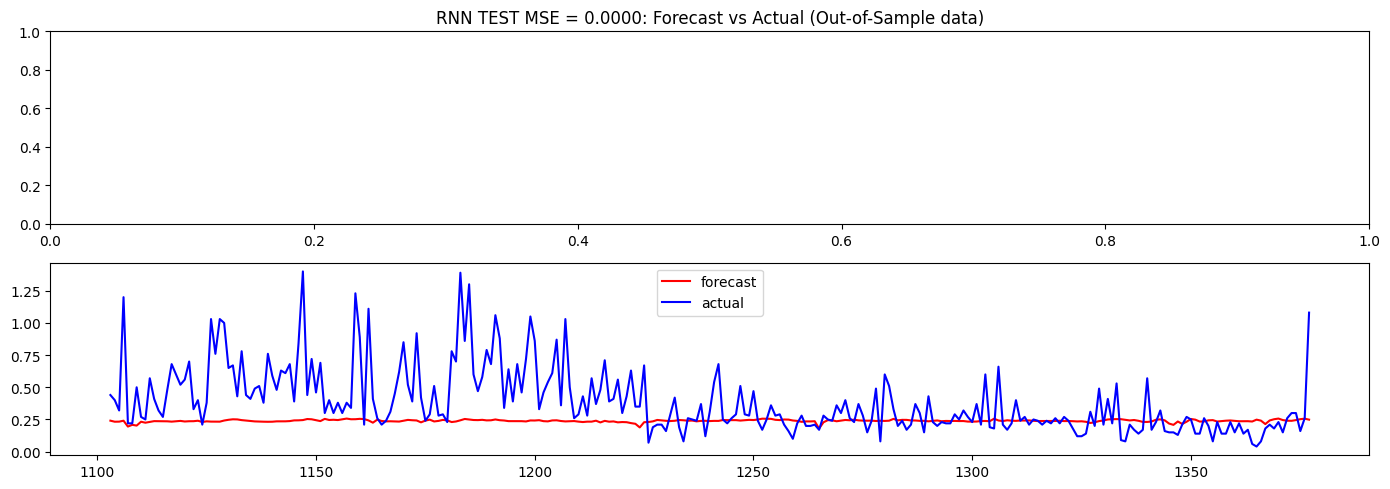

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


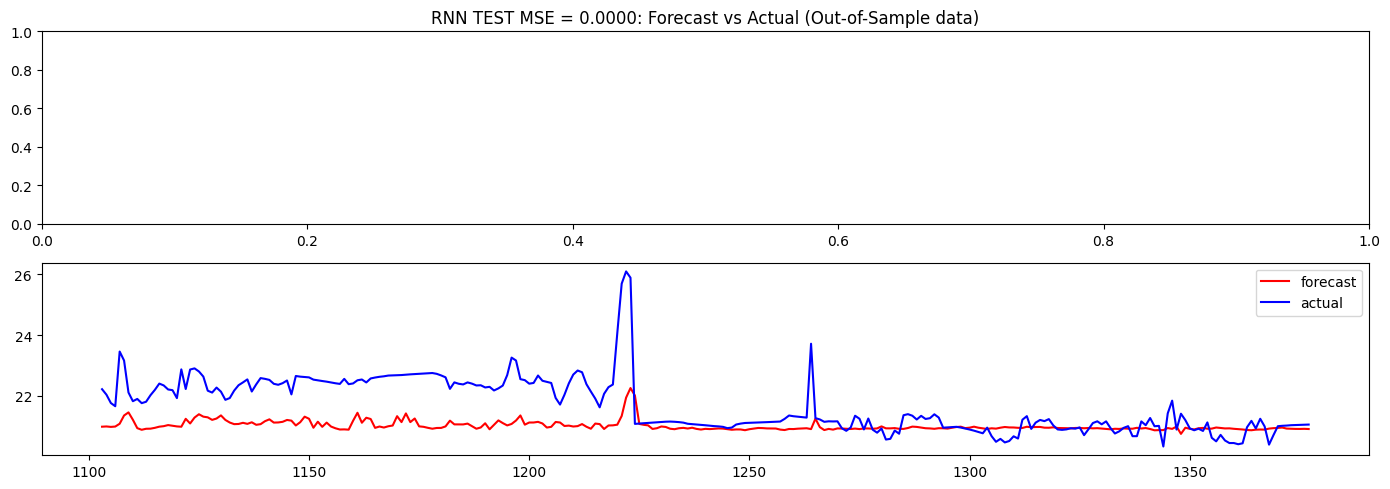

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


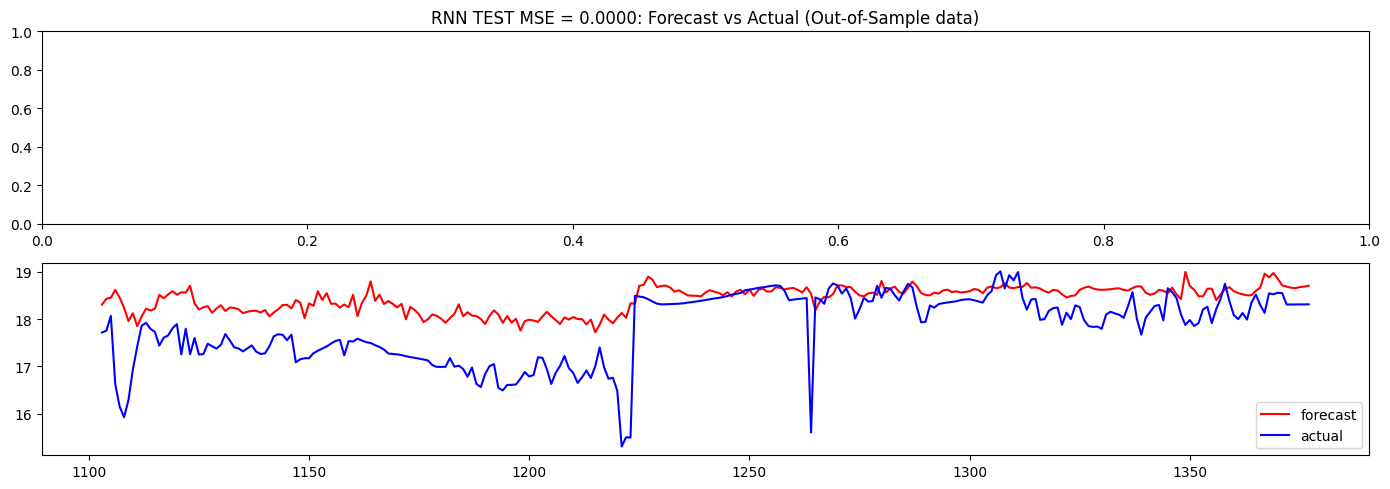

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


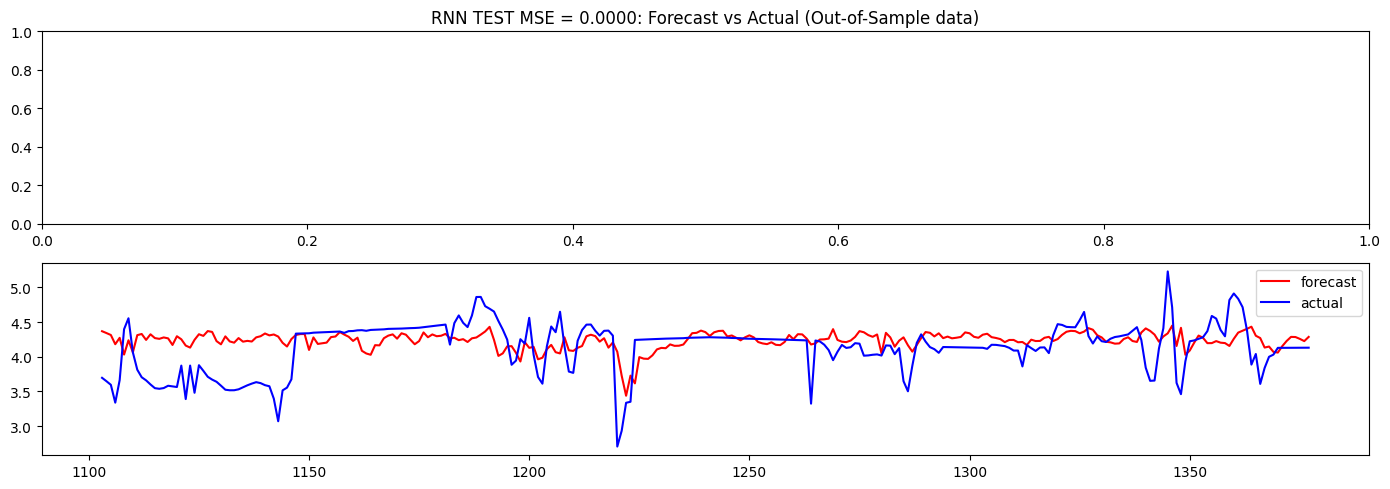

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


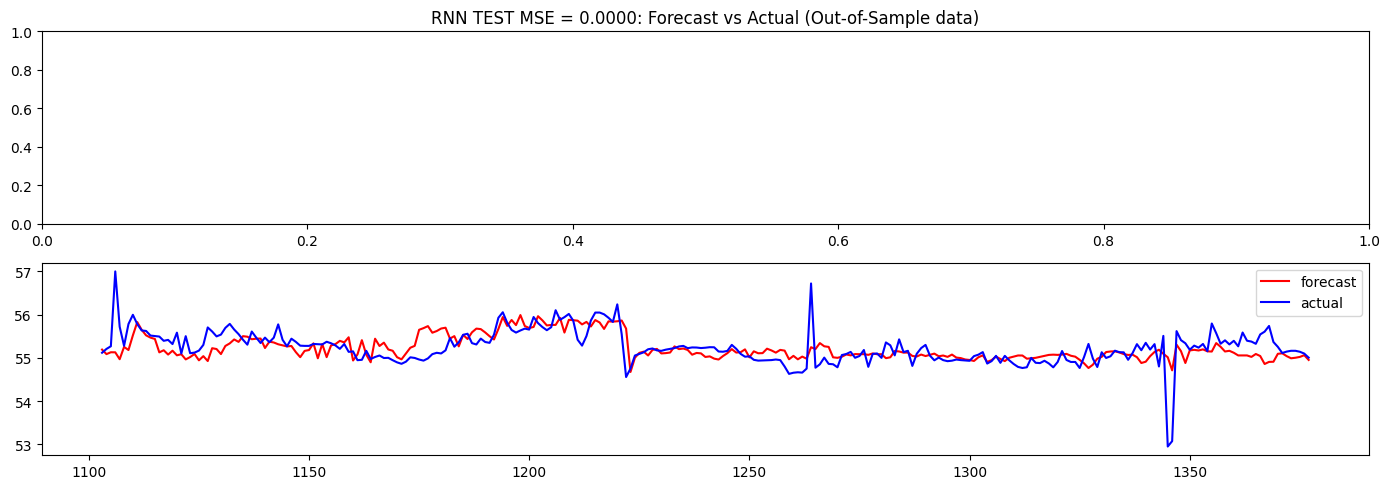

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


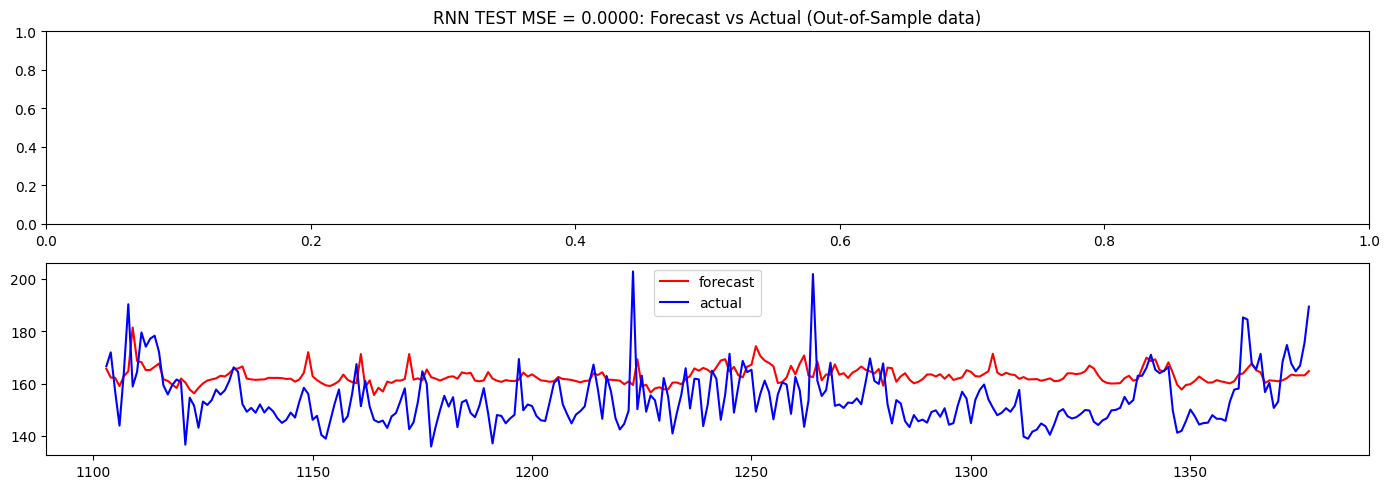

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


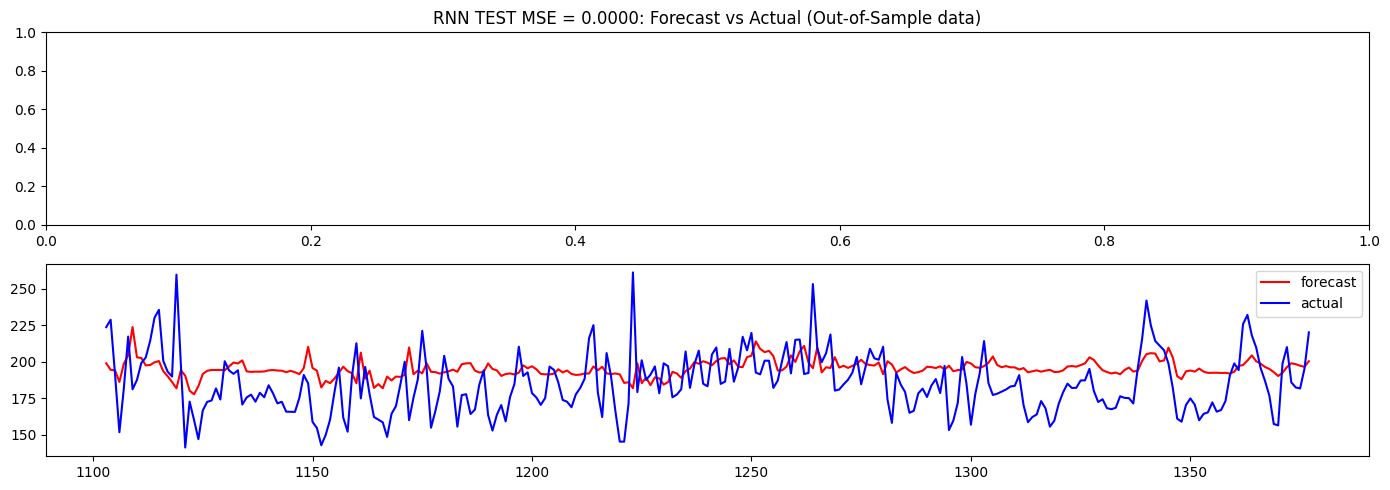

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


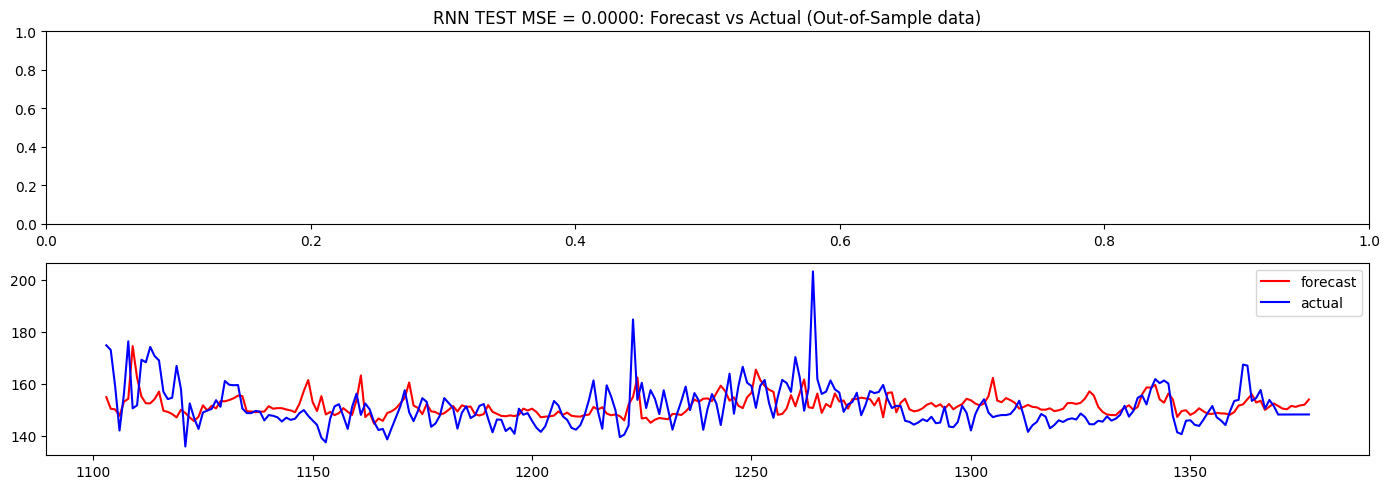

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


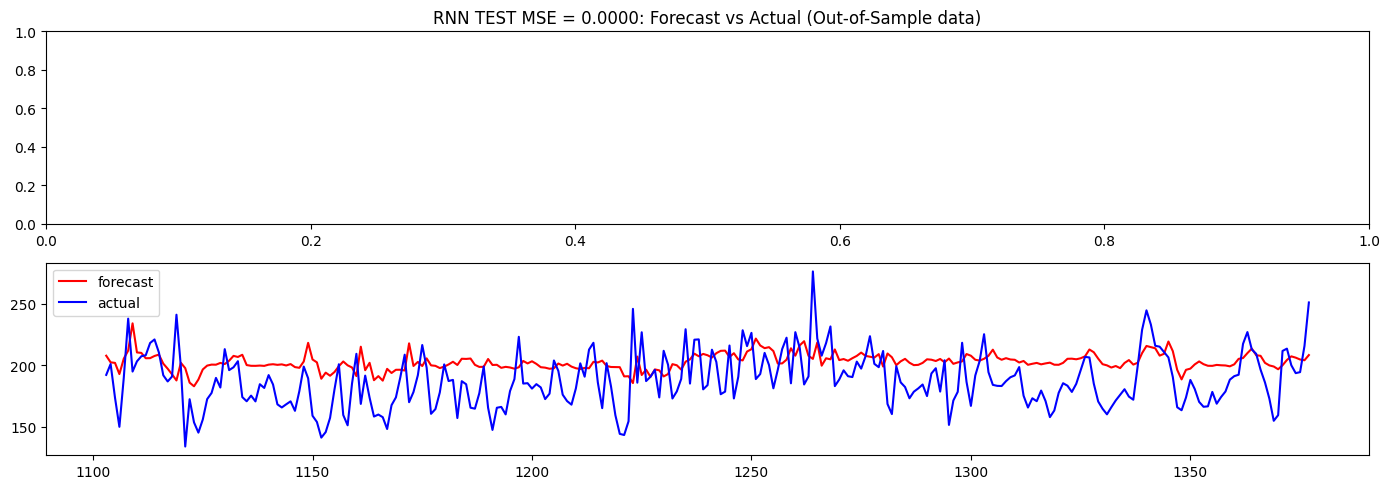

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


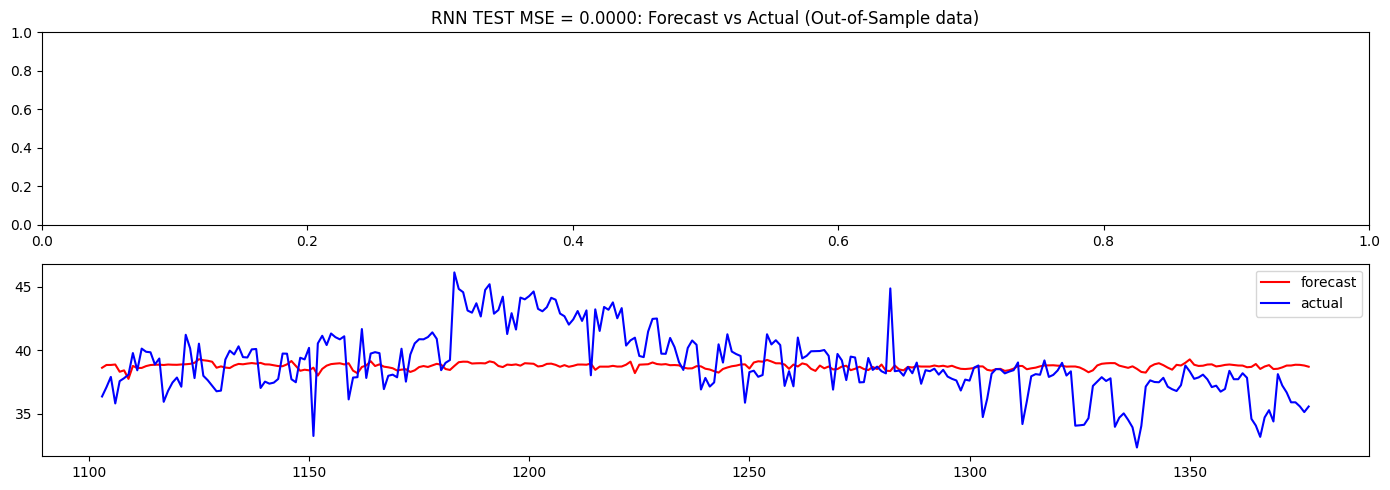

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


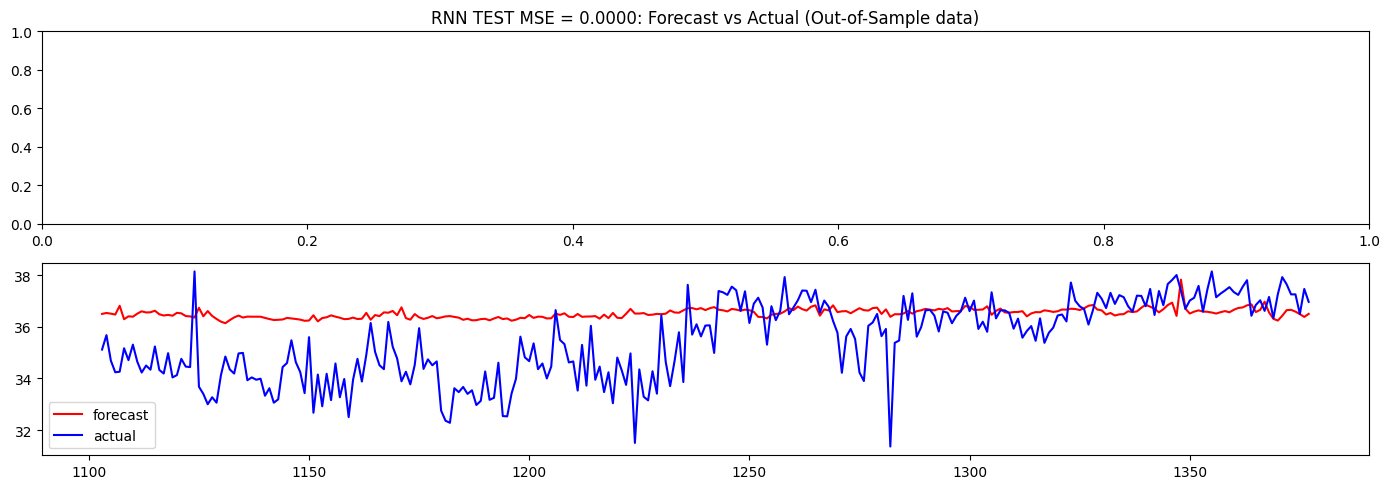

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


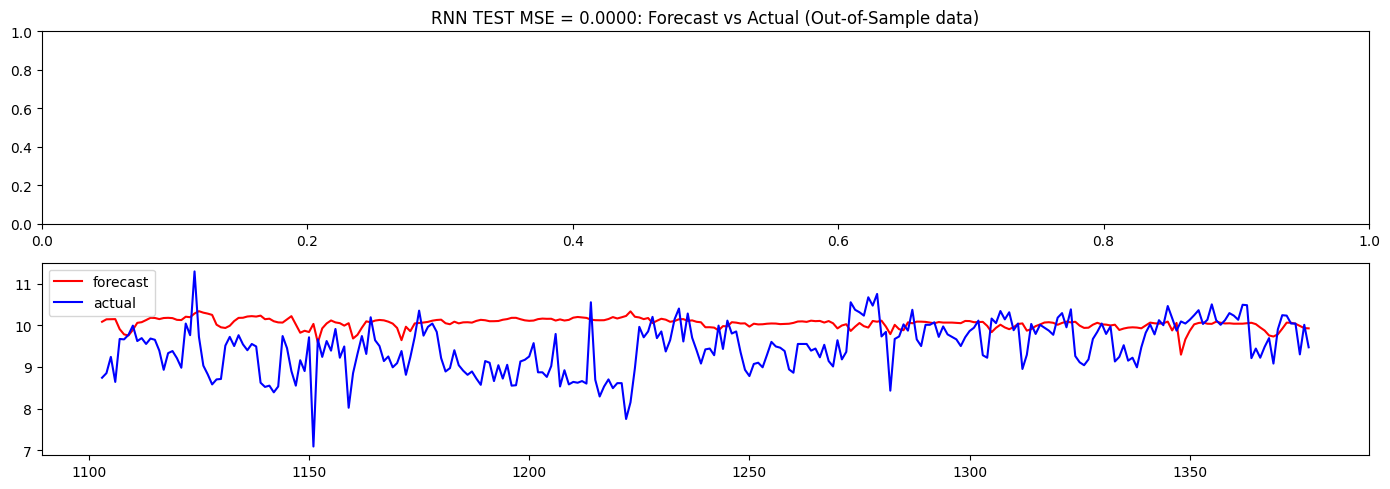

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


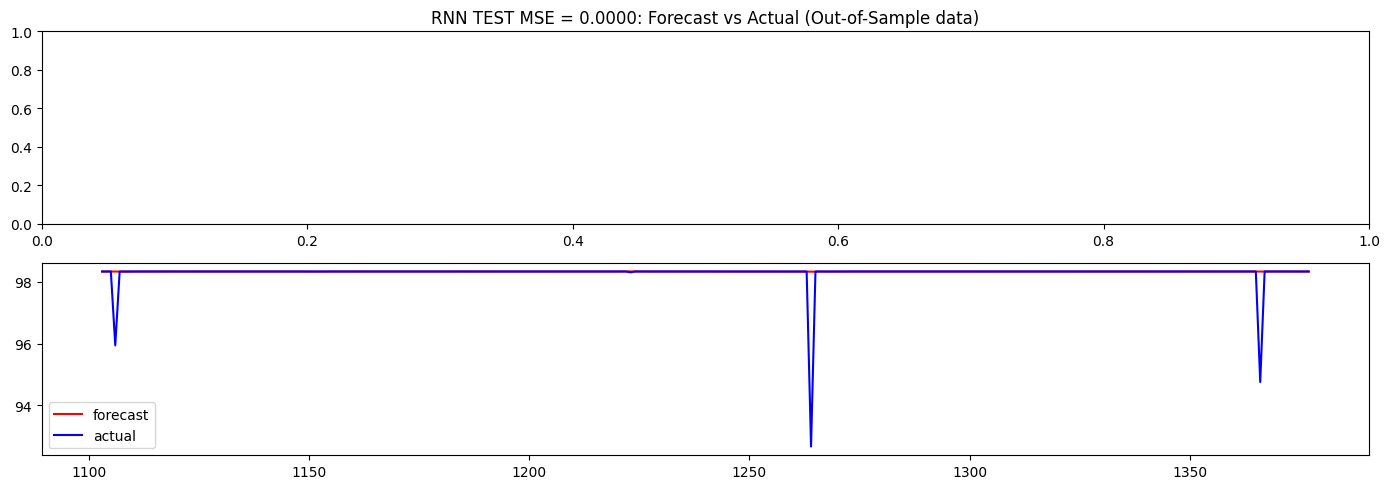

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


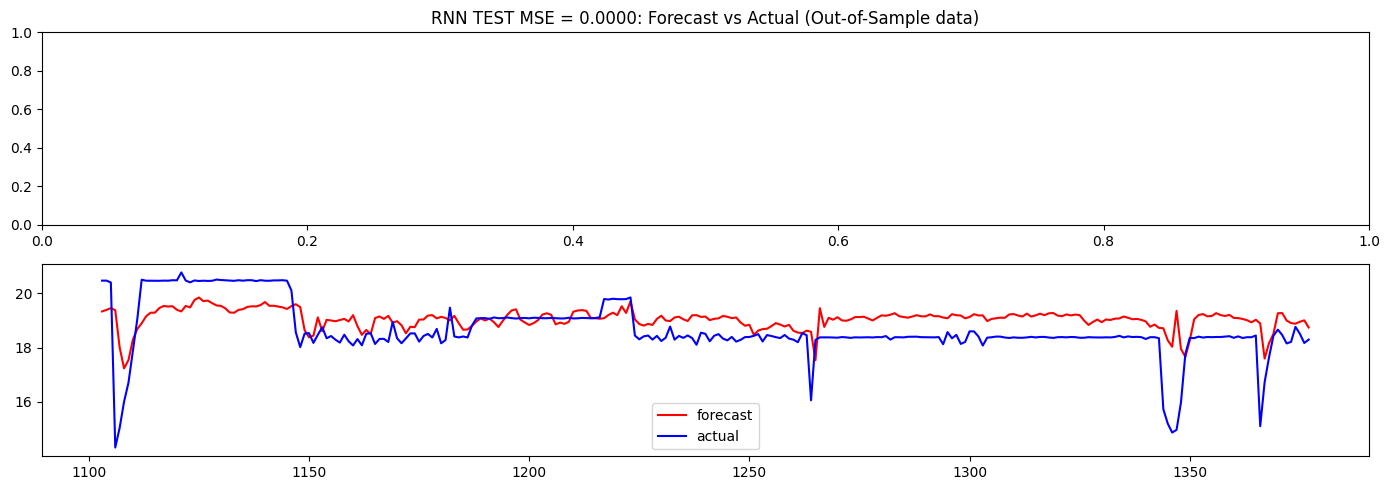

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


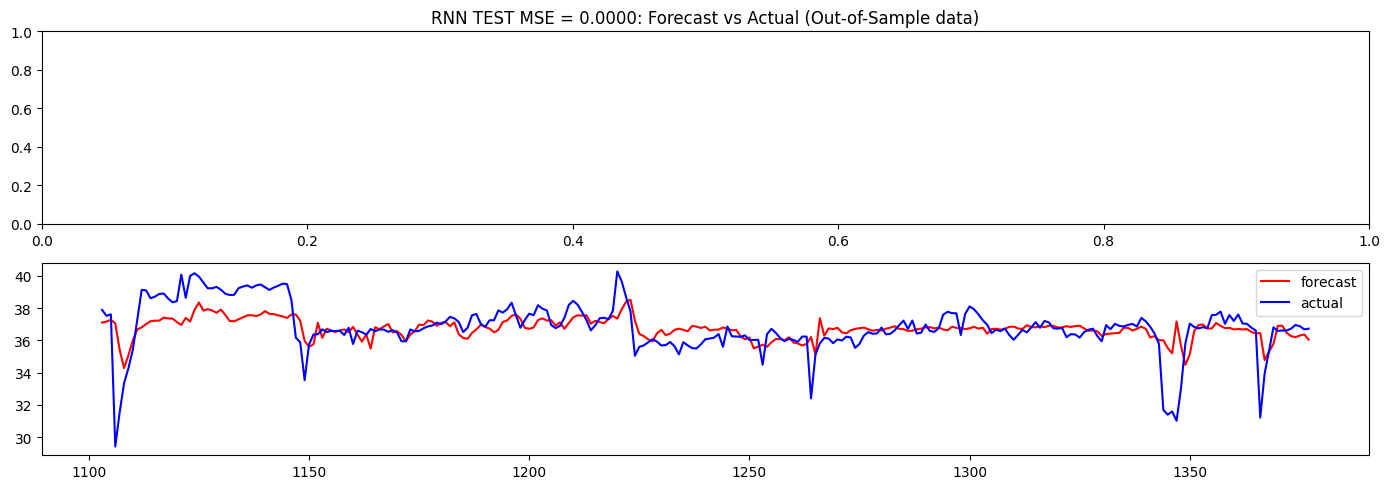

ricardo check this
torch.Size([275, 24])
torch.Size([275, 24])
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(144,)
(144,)
(24,)
(24,)
(275, 24)
(1, 24)
(1, 24)
(275, 24)
(275, 24)


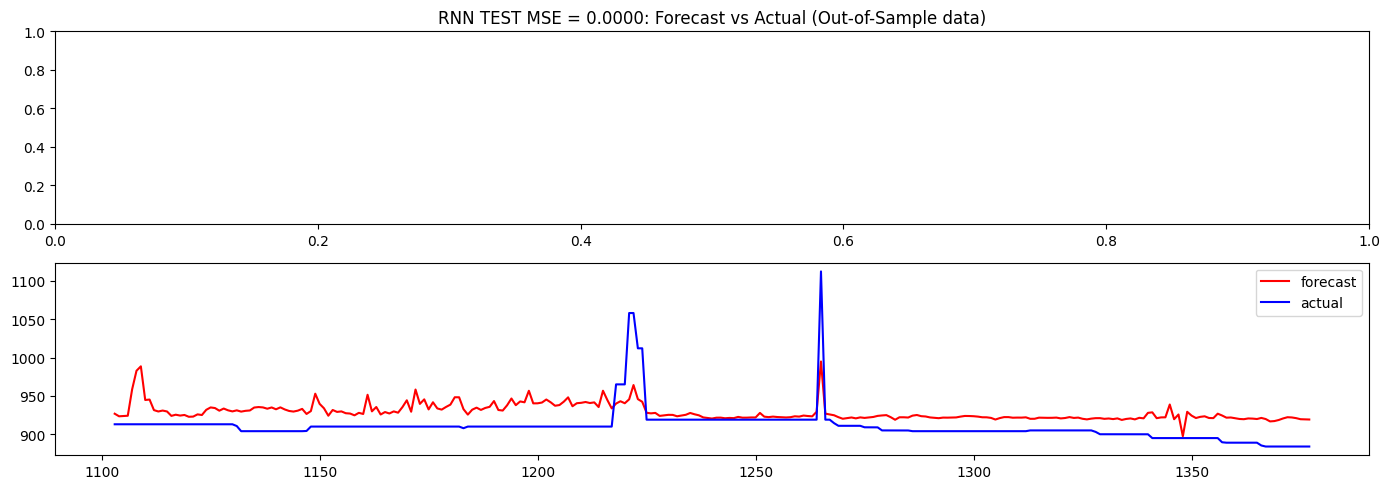

In [115]:

for i in range(24):

    x_index = i

    l1, l2 = View_all_predicted_Xs(x_index, model, model_type='RNN', **params_si )            
